In [1]:
!pip install duckdb jupysql duckdb-engine dython pycaret numpy --upgrade --user dowhy --upgrade --user --quiet 

# !pip install --quiet chart-studiot
# !pip install --quiet pandas_profiling

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
chex 0.1.82 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.24.4 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.4 which is incompatible.
ydata-profiling 4.3.1 requires numpy<1.2

# Objective:

### 1. Analyze driver’s Lifetime Value (LTV) 
### 2. Using the data provided, identify trends and insights of the factors that impact LTV

* Notes about data: drivers may have continued after last recording in dataset
* Make sure to state all assumptions (when modeling)

In [2]:
import warnings
warnings.simplefilter("ignore")

# data engineering
import duckdb
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# data processing, compute, auto-EDA
import numpy as np
# import scipy
from scipy import stats
from scipy.stats import kstest
from scipy.stats import normaltest
import pandas as pd 
# from pandas_profiling import ProfileReport

# visualizations for EDA
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns

# correlation scores
# from sklearn.metrics import jaccard_score
# from dython.nominal import associations
# from dython.nominal import identify_nominal_columns

# feature importance
# from pycaret.classification import *
# from pycaret.regression import *

# causality inference
# from dowhy import CausalModel

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

# Data

In [3]:
drivers = pd.read_csv('/kaggle/input/lyftdatachallenge/driver_ids.csv')
rides = pd.read_csv('/kaggle/input/lyftdatachallenge/ride_ids.csv')
ride_timestamps = pd.read_csv('/kaggle/input/lyftdatachallenge/ride_timestamps.csv')
# combined = pd.read_csv('/kaggle/input/lyft-analysis/combined_lyft_dataset.csv')

In [4]:
drivers.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


In [5]:
rides.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [6]:
drivers.info(),
print('         '),
rides.info(), 
print('         '),
ride_timestamps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   driver_id            937 non-null    object
 1   driver_onboard_date  937 non-null    object
dtypes: object(2)
memory usage: 14.8+ KB
         
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   driver_id        193502 non-null  object
 1   ride_id          193502 non-null  object
 2   ride_distance    193502 non-null  int64 
 3   ride_duration    193502 non-null  int64 
 4   ride_prime_time  193502 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 7.4+ MB
         
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970405 entries, 0 to 970404
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  --

In [7]:
# Change ts to pandas datetime
drivers['driver_onboard_date'] = pd.to_datetime(drivers['driver_onboard_date'])
ride_timestamps['timestamp'] = pd.to_datetime(ride_timestamps['timestamp'])

In [8]:
# Descriptive Stat's exluding timestamps until EDA
rides.describe()

,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


In [9]:
drivers.isnull().sum(), rides.isnull().sum(), ride_timestamps.isnull().sum()

(driver_id              0
 driver_onboard_date    0
 dtype: int64,
 driver_id          0
 ride_id            0
 ride_distance      0
 ride_duration      0
 ride_prime_time    0
 dtype: int64,
 ride_id      0
 event        0
 timestamp    1
 dtype: int64)

In [10]:
# Taking care of this NULL right now since will forget (delete/impute with mean)
query = """
select *
from ride_timestamps
where timestamp IS NULL
"""

duckdb.query(query).df()

,ride_id,event,timestamp
0,72f0fa0bd86800e9da5c4dced32c8735,arrived_at,NaT


In [11]:
# is it really worth it if it is only a small percentage of rides? will perform impute anyway
1/len(ride_timestamps)

1.030497575754453e-06

In [12]:
# though this ride has 5 events. if delete this, will lose info on 4 other events.
query = """
select *
from ride_timestamps
where ride_id in (select ride_id from ride_timestamps
where timestamp IS NULL)
"""

duckdb.query(query).df()

,ride_id,event,timestamp
0,72f0fa0bd86800e9da5c4dced32c8735,requested_at,2016-04-20 11:56:50
1,72f0fa0bd86800e9da5c4dced32c8735,accepted_at,2016-04-20 11:57:20
2,72f0fa0bd86800e9da5c4dced32c8735,arrived_at,NaT
3,72f0fa0bd86800e9da5c4dced32c8735,picked_up_at,2016-04-20 12:02:20
4,72f0fa0bd86800e9da5c4dced32c8735,dropped_off_at,2016-04-20 12:16:30


In [13]:
# Given that this is a needed ts down the data analysis pipeline, 
# will impute with average time difference between dropped_off_at and arrived_at 
# and add calculated ts to replace NaT

# Get average diff between arrived_at and accepted_at
# Determine duration to subsequent step in rider journey
query = """
with time_next as (
select *
, lead(timestamp, 1) over (partition by ride_id order by timestamp) as next_event_time
from ride_timestamps
where event in ('accepted_at', 'arrived_at')
)

, timediff as (select *
, case when event = 'accepted_at' then date_diff('second', timestamp, next_event_time) end as arrive_dur_sec
from time_next
order by ride_id, timestamp
)

select avg(arrive_dur_sec)
from timediff
"""

duckdb.query(query).df() 

# for longer durations, seconds converted to min (arrival and drop off durations)
# rider_journey = duckdb.query(query).df() 
# rider_journey

,avg(arrive_dur_sec)
0,247.769827


In [14]:
# Add 248 seconds to accepted_at ts: 2016-04-20 11:57:20 to impute ride id: 72f0fa0bd86800e9da5c4dced32c8735's arrived at ts

# for generic (if did not have one data point to impute) do conditional impute
# on null in arrived_at vs when ride_id = ___

query = """

with time_prev as (
select *
, lag(timestamp, 1) over (partition by ride_id 
ORDER BY  case when event = 'requested_at' then 1
                when event = 'accepted_at' then 2
                when event = 'arrived_at' then 3
                when event = 'picked_up_at' then 4
                when event = 'dropped_off_at' then 5
                end asc) as prev_event_time
from ride_timestamps
)

select ride_id
, event
, coalesce(timestamp,case when event = 'arrived_at' and timestamp IS NULL 
then prev_event_time + interval 248 SECOND
else timestamp end) as timestamp
from time_prev
-- where ride_id in ('72f0fa0bd86800e9da5c4dced32c8735', '0002090d41c4050b1683e3c4f69ed1c4', 'fffa5815788aa758c8aa3f839860f57e')
order by ride_id
, case when event = 'requested_at' then 1
                when event = 'accepted_at' then 2
                when event = 'arrived_at' then 3
                when event = 'picked_up_at' then 4
                when event = 'dropped_off_at' then 5
                end 
"""

ride_timestamps = duckdb.query(query).df() 
ride_timestamps

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05
...,...,...,...
970400,ffffccd77f47a3de26dfed9a851464b4,requested_at,2016-05-18 08:44:13
970401,ffffccd77f47a3de26dfed9a851464b4,accepted_at,2016-05-18 08:44:21
970402,ffffccd77f47a3de26dfed9a851464b4,arrived_at,2016-05-18 08:44:36
970403,ffffccd77f47a3de26dfed9a851464b4,picked_up_at,2016-05-18 08:44:42


# Data Quality Check- duplications, outliers, non-sense data

## Duplications

In [15]:
query = """
select count(*) as total_rows
, count(distinct driver_id) as unique_drivers
from drivers
"""

duckdb.query(query).df()

,total_rows,unique_drivers
0,937,937


In [16]:
query = """
select count(*) as total_ride_rows
, count(distinct ride_id) as unique_rides
from rides
"""

duckdb.query(query).df() 

,total_ride_rows,unique_rides
0,193502,193502


In [17]:
# Check if each ride_id has 5 distinct events
query = """
select ride_id
, count(distinct event) as unique_events
from ride_timestamps
group by 1
having count(distinct event) != 5
"""

duckdb.query(query).df() 

,ride_id,unique_events


## Join Tables 
* Due to mainly looking at drivers' behavior, we want to take into account all drivers
* So will left join drivers to rides and inner join ride_timestamps to rides
* This will reduce data to compute 
* First let us pivot the ride timestamps event to have per row ride

In [18]:
# Let us first convert timestamps pd dt objects and then into business prob parts
# Data only spans 3 months (and drivers could have completed more rides after this snapshot)
# so make month and day features (Early Feature Engineering)

drivers['driver_onboard_date'] = pd.to_datetime(drivers['driver_onboard_date'])
ride_timestamps['timestamp'] = pd.to_datetime(ride_timestamps['timestamp'])

drivers['driver_onboard_month'] = drivers['driver_onboard_date'].dt.month
drivers['driver_onboard_week'] = drivers['driver_onboard_date'].dt.isocalendar().week
drivers['driver_onboard_day'] = drivers['driver_onboard_date'].dt.day
# drivers.drop(columns=['driver_onboard_date'], inplace=True)
drivers.head()

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_week,driver_onboard_day
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,3,13,29
1,007f0389f9c7b03ef97098422f902e62,2016-03-29,3,13,29
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05,4,14,5
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23,4,16,23
4,01674381af7edd264113d4e6ed55ecda,2016-04-29,4,17,29


In [19]:
# Pivot table by ride event timestamp so each row is a distinct ride_id with each event's ts
# Below uses DuckDB, but computation is much heavier

# ride_ts_pivot = duckdb.query('PIVOT ride_timestamps ON event USING FIRST(timestamp)').df() 
# ride_ts_pivot = ride_ts_pivot[['ride_id', 'requested_at', 'accepted_at', 'arrived_at', 'picked_up_at', 'dropped_off_at']]
# ride_ts_pivot = duckdb.query('select * from ride_ts_pivot order by ride_id').df()
# ride_ts_pivot.head()

In [20]:
query = """
select ride_id
, MAX(case when event = 'requested_at' then timestamp end) as requested_at_ts
, MAX(case when event = 'accepted_at' then timestamp end) as accepted_at_ts
, MAX(case when event = 'arrived_at' then timestamp end) as arrived_at_ts
, MAX(case when event = 'picked_up_at' then timestamp end) as picked_up_at_ts
, MAX(case when event = 'dropped_off_at' then timestamp end) as dropped_off_at_ts
from ride_timestamps
group by 1
"""
ride_timestamps2 = duckdb.query(query).df() 
ride_timestamps2

,ride_id,requested_at_ts,accepted_at_ts,arrived_at_ts,picked_up_at_ts,dropped_off_at_ts
0,50f8bc23e4a1d9d4ae7d8b1cbcd5acab,2016-05-24 16:37:21,2016-05-24 16:37:27,2016-05-24 16:39:00,2016-05-24 16:39:00,2016-05-24 16:51:50
1,50f8ebab7b078805232d661da04473fd,2016-05-08 15:41:51,2016-05-08 15:41:59,2016-05-08 15:42:04,2016-05-08 15:42:06,2016-05-08 15:56:58
2,50f9605b667f63ab7e333265b19a965b,2016-06-04 18:38:34,2016-06-04 18:38:39,2016-06-04 18:40:23,2016-06-04 18:40:26,2016-06-04 18:56:39
3,50f97463dfe9db8aba97277b7f5b6942,2016-06-12 00:24:57,2016-06-12 00:25:10,2016-06-12 00:30:11,2016-06-12 00:30:19,2016-06-12 00:37:05
4,50f9d315eafcc4af97f29c6579d7ecc1,2016-05-02 10:04:14,2016-05-02 10:04:28,2016-05-02 10:09:38,2016-05-02 10:09:38,2016-05-02 10:19:45
...,...,...,...,...,...,...
194076,f310f67a57a49d7830253fc9feffde44,2016-04-30 14:36:36,2016-04-30 14:36:39,2016-04-30 14:40:24,2016-04-30 14:40:29,2016-04-30 15:15:28
194077,f3120a0c0adcf517304a5e1194ea68c4,2016-06-17 21:27:03,2016-06-17 21:27:08,2016-06-17 21:29:16,2016-06-17 21:30:16,2016-06-17 21:44:26
194078,f313385adf1fd70032b4089ae1ecea3d,2016-05-06 21:47:36,2016-05-06 21:47:42,2016-05-06 21:52:14,2016-05-06 21:52:16,2016-05-06 21:59:38
194079,f315c62ffe1a10f5f7ee56b148770bdb,2016-05-16 23:03:34,2016-05-16 23:03:45,2016-05-16 23:09:00,2016-05-16 23:09:02,2016-05-16 23:49:09


In [21]:
query = """
select d.driver_id
, driver_onboard_date
, driver_onboard_month
, driver_onboard_day
, driver_onboard_week
, r.ride_id
, ride_distance
, ride_duration
, ride_prime_time
, requested_at_ts
, accepted_at_ts
, arrived_at_ts
, picked_up_at_ts
, dropped_off_at_ts
from drivers d
left join rides r
on d.driver_id = r.driver_id
join ride_timestamps2 rt
on r.ride_id = rt.ride_id
"""
df = duckdb.query(query).df() 
df

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_day,driver_onboard_week,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at_ts,accepted_at_ts,arrived_at_ts,picked_up_at_ts,dropped_off_at_ts
0,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,d1f12354ce9bf47223b43c5735e3e9bd,2682,370,0,2016-04-20 14:24:19,2016-04-20 14:24:23,2016-04-20 14:34:54,2016-04-20 14:34:53,2016-04-20 14:41:03
1,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,daa6e7e938dad5f14be37d5c44006a11,19488,1738,0,2016-04-06 18:53:36,2016-04-06 18:53:41,2016-04-06 19:03:25,2016-04-06 19:03:28,2016-04-06 19:32:26
2,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,dc5f57bb879a22e78436b92baf47795c,8645,759,0,2016-04-18 19:29:30,2016-04-18 19:29:32,2016-04-18 19:40:23,2016-04-18 19:40:24,2016-04-18 19:53:03
3,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,e494174cf3d725256f197727da985338,17741,911,0,2016-04-22 05:52:12,2016-04-22 05:52:18,2016-04-22 06:01:19,2016-04-22 06:01:20,2016-04-22 06:16:31
4,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,ed68b2461d6632366f76bf94fb609cf8,8045,947,0,2016-04-14 18:47:52,2016-04-14 18:47:55,2016-04-14 18:50:22,2016-04-14 18:50:24,2016-04-14 19:06:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184204,7b8eaf284addb604039c7e22d23c903f,2016-04-05,4,5,14,fbc20acab8ac763fd8e33a120cde53ff,2837,383,0,2016-04-28 20:08:10,2016-04-28 20:08:14,2016-04-28 20:13:42,2016-04-28 20:13:41,2016-04-28 20:20:04
184205,7b8eaf284addb604039c7e22d23c903f,2016-04-05,4,5,14,fd0ecffd81279473cd94eb067a8a3e3f,2990,495,0,2016-05-21 18:22:23,2016-05-21 18:22:37,2016-05-21 18:27:07,2016-05-21 18:27:07,2016-05-21 18:35:22
184206,7b8eaf284addb604039c7e22d23c903f,2016-04-05,4,5,14,fdd0a105825e032d2a503cd92d46396c,34251,1843,0,2016-05-03 18:44:49,2016-05-03 18:44:57,2016-05-03 18:51:31,2016-05-03 18:51:34,2016-05-03 19:22:17
184207,7b8eaf284addb604039c7e22d23c903f,2016-04-05,4,5,14,ff002ec3535a1a98ffa2b95f63e58918,2900,376,0,2016-05-19 06:59:53,2016-05-19 06:59:59,2016-05-19 07:03:52,2016-05-19 07:03:51,2016-05-19 07:10:07


In [22]:
# checking expected numbers
print('Is final df less than or equal to total rides given?', len(df) <= len(ride_timestamps2))
df.isnull().sum()

Is final df less than or equal to total rides given? True


driver_id               0
driver_onboard_date     0
driver_onboard_month    0
driver_onboard_day      0
driver_onboard_week     0
ride_id                 0
ride_distance           0
ride_duration           0
ride_prime_time         0
requested_at_ts         0
accepted_at_ts          0
arrived_at_ts           0
picked_up_at_ts         0
dropped_off_at_ts       0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184209 entries, 0 to 184208
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   driver_id             184209 non-null  object        
 1   driver_onboard_date   184209 non-null  datetime64[ns]
 2   driver_onboard_month  184209 non-null  int32         
 3   driver_onboard_day    184209 non-null  int32         
 4   driver_onboard_week   184209 non-null  uint32        
 5   ride_id               184209 non-null  object        
 6   ride_distance         184209 non-null  int64         
 7   ride_duration         184209 non-null  int64         
 8   ride_prime_time       184209 non-null  int64         
 9   requested_at_ts       184209 non-null  datetime64[ns]
 10  accepted_at_ts        184209 non-null  datetime64[ns]
 11  arrived_at_ts         184209 non-null  datetime64[ns]
 12  picked_up_at_ts       184209 non-null  datetime64[ns]
 13 

# EDA
## Outliers (Continuous Data) / Rare Values

## Discrete Data

<Axes: xlabel='driver_onboard_month', ylabel='Density'>

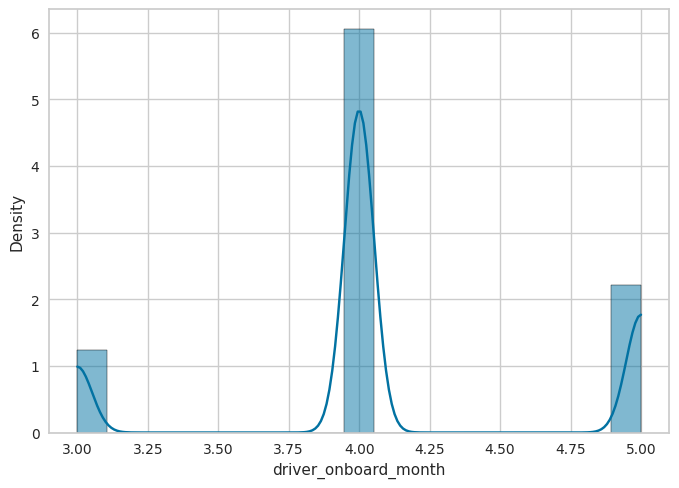

In [24]:
sns.histplot(df['driver_onboard_month'], kde=True, stat="density")

<Axes: xlabel='driver_onboard_day', ylabel='Density'>

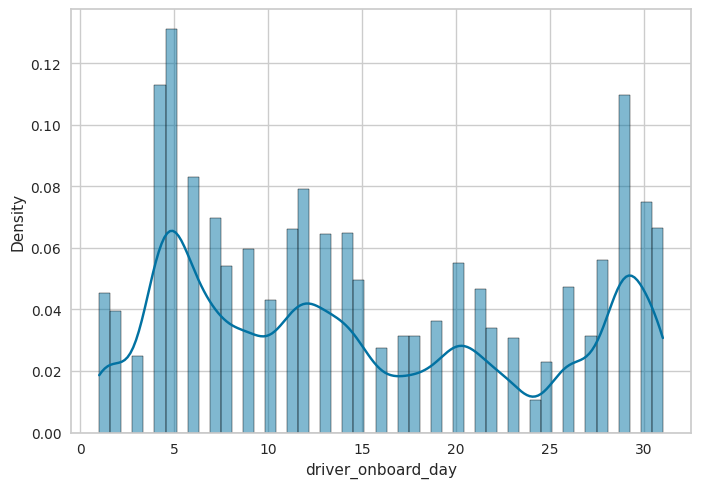

In [25]:
sns.histplot(df['driver_onboard_day'], kde=True, stat="density")

<Axes: xlabel='driver_onboard_week', ylabel='Density'>

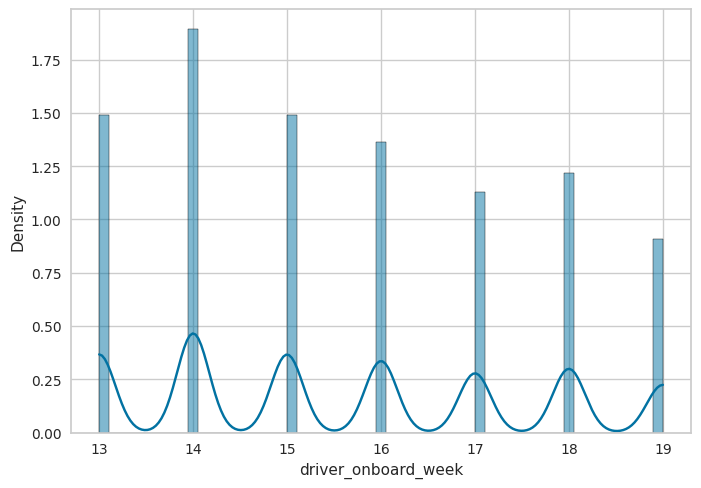

In [26]:
sns.histplot(df['driver_onboard_week'], kde=True, stat="density")

Majority of drivers onboarded in April, beginning and end of month and 14th week of the 2016.

In [27]:
# Discrete value.(For feature engineering, may benefit to bin)
df['ride_prime_time'].value_counts()

ride_prime_time
0      119107
25      32184
50      16966
75       7811
100      5989
150      1594
200       409
250        95
300        29
350        13
400        11
500         1
Name: count, dtype: int64

## Continuous Data
distance, duration, events_ts_diff

In [28]:
# distance (meters -> miles)
df['ride_distance_mil'] = df['ride_distance'] * 0.000621371

# duration (seconds -> minutes)
# df['ride_duration_min'] = df['ride_duration']/60
df['ride_duration_sec'] = df['ride_duration']
df.drop(columns=['ride_duration'], inplace=True)

In [29]:
df['ride_distance_mil'].describe()

count    184209.000000
mean          4.315544
std           5.553824
min          -0.001243
25%           1.526709
50%           2.489834
75%           4.454609
max         450.294515
Name: ride_distance_mil, dtype: float64

In [30]:
# Percentage of neg values in ride_distance_mil
len(df[df['ride_distance_mil'] <0])/len(df['ride_distance_mil']) # only 1 value; could also just replace with 0

5.428616408535956e-06

In [31]:
# Impute with mean to not remove info from other rides

query = """

with cte as (select case when ride_distance_mil < 0 then NULL else ride_distance_mil end as ride_distance_mil2
from df)

, cte2 as (select avg(ride_distance_mil) as mean_ride_distance_mil
from df 
where ride_distance_mil > 0
)

select case when ride_distance_mil2 IS NULL then (select mean_ride_distance_mil from cte2) else ride_distance_mil2 end as ride_distance_mil2
from cte
"""
impute_col = duckdb.query(query).df()
impute_col

df['ride_distance_mil'] = impute_col
df['ride_distance_mil'].describe()

count    184209.000000
mean          4.315567
std           5.553815
min           0.000000
25%           1.526709
50%           2.489834
75%           4.454609
max         450.294515
Name: ride_distance_mil, dtype: float64

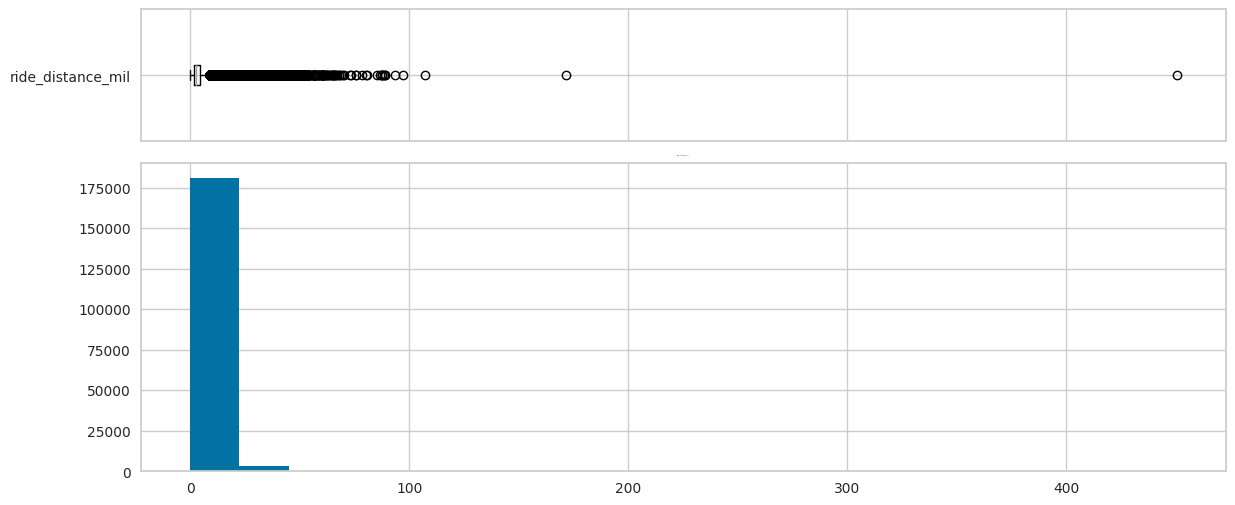

In [32]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="ride_distance_mil",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="ride_distance_mil", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

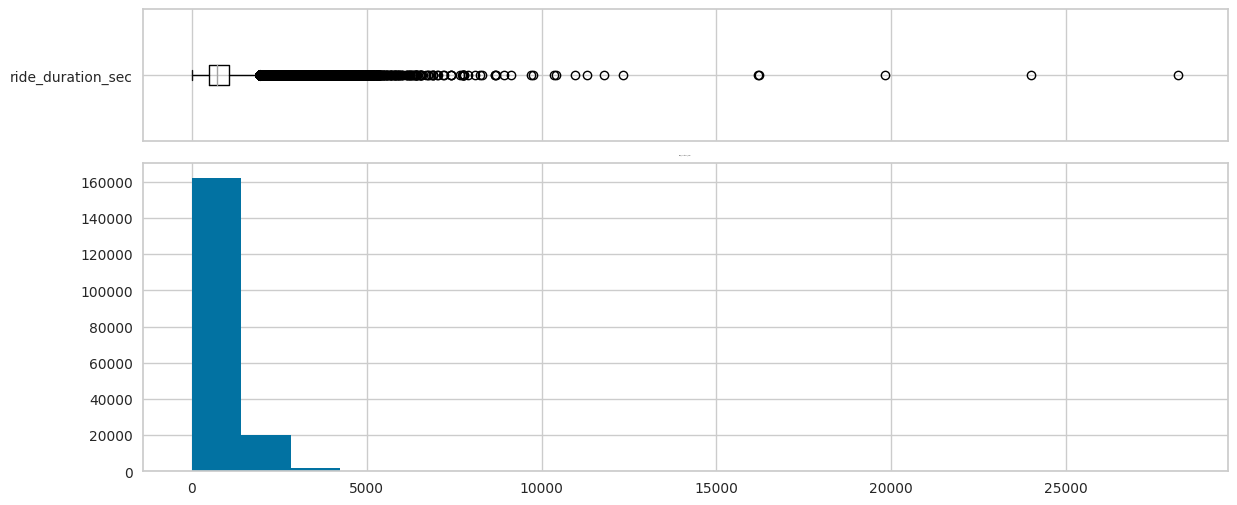

In [33]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="ride_duration_sec",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="ride_duration_sec", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

In [34]:
# ride durations between each event prior to ride

query = """

select * -- exclude (requested_at_ts, accepted_at_ts, arrived_at_ts, picked_up_at_ts, dropped_off_at_ts)
, date_diff('second',requested_at_ts, accepted_at_ts) as accepted_at_dur_sec
, date_diff('second',accepted_at_ts, arrived_at_ts) as arrived_at_dur_sec
, date_diff('second',arrived_at_ts, picked_up_at_ts) as picked_up_at_dur_sec
-- , date_diff('second',picked_up_at_ts, dropped_off_at_ts) as dropped_off_at_dur_sec --not needed since same as ride_duration_min
from df

"""
df = duckdb.query(query).df()
df

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_day,driver_onboard_week,ride_id,ride_distance,ride_prime_time,requested_at_ts,accepted_at_ts,arrived_at_ts,picked_up_at_ts,dropped_off_at_ts,ride_distance_mil,ride_duration_sec,accepted_at_dur_sec,arrived_at_dur_sec,picked_up_at_dur_sec
0,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,d1f12354ce9bf47223b43c5735e3e9bd,2682,0,2016-04-20 14:24:19,2016-04-20 14:24:23,2016-04-20 14:34:54,2016-04-20 14:34:53,2016-04-20 14:41:03,1.666517,370,4,631,-1
1,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,daa6e7e938dad5f14be37d5c44006a11,19488,0,2016-04-06 18:53:36,2016-04-06 18:53:41,2016-04-06 19:03:25,2016-04-06 19:03:28,2016-04-06 19:32:26,12.109278,1738,5,584,3
2,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,dc5f57bb879a22e78436b92baf47795c,8645,0,2016-04-18 19:29:30,2016-04-18 19:29:32,2016-04-18 19:40:23,2016-04-18 19:40:24,2016-04-18 19:53:03,5.371752,759,2,651,1
3,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,e494174cf3d725256f197727da985338,17741,0,2016-04-22 05:52:12,2016-04-22 05:52:18,2016-04-22 06:01:19,2016-04-22 06:01:20,2016-04-22 06:16:31,11.023743,911,6,541,1
4,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,ed68b2461d6632366f76bf94fb609cf8,8045,0,2016-04-14 18:47:52,2016-04-14 18:47:55,2016-04-14 18:50:22,2016-04-14 18:50:24,2016-04-14 19:06:11,4.998930,947,3,147,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184204,7b8eaf284addb604039c7e22d23c903f,2016-04-05,4,5,14,fbc20acab8ac763fd8e33a120cde53ff,2837,0,2016-04-28 20:08:10,2016-04-28 20:08:14,2016-04-28 20:13:42,2016-04-28 20:13:41,2016-04-28 20:20:04,1.762830,383,4,328,-1
184205,7b8eaf284addb604039c7e22d23c903f,2016-04-05,4,5,14,fd0ecffd81279473cd94eb067a8a3e3f,2990,0,2016-05-21 18:22:23,2016-05-21 18:22:37,2016-05-21 18:27:07,2016-05-21 18:27:07,2016-05-21 18:35:22,1.857899,495,14,270,0
184206,7b8eaf284addb604039c7e22d23c903f,2016-04-05,4,5,14,fdd0a105825e032d2a503cd92d46396c,34251,0,2016-05-03 18:44:49,2016-05-03 18:44:57,2016-05-03 18:51:31,2016-05-03 18:51:34,2016-05-03 19:22:17,21.282578,1843,8,394,3
184207,7b8eaf284addb604039c7e22d23c903f,2016-04-05,4,5,14,ff002ec3535a1a98ffa2b95f63e58918,2900,0,2016-05-19 06:59:53,2016-05-19 06:59:59,2016-05-19 07:03:52,2016-05-19 07:03:51,2016-05-19 07:10:07,1.801976,376,6,233,-1


<Axes: >

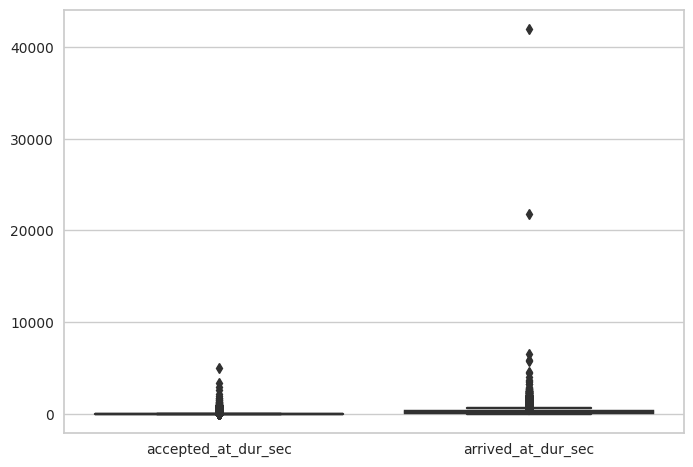

In [35]:
# Distribution duration segments
sns.boxplot(data=df[['accepted_at_dur_sec', 'arrived_at_dur_sec']])

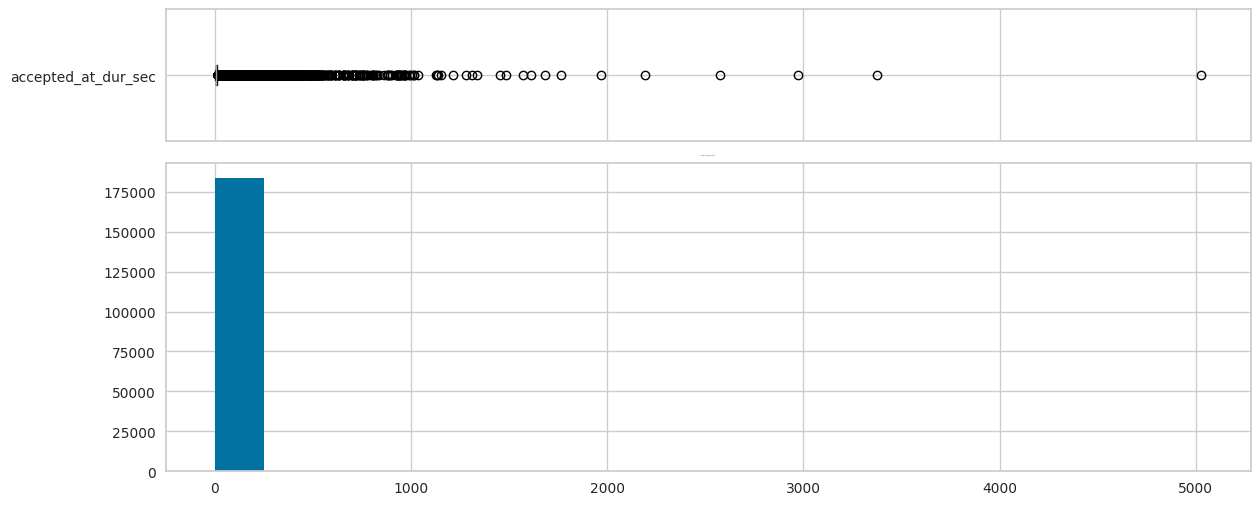

In [36]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="accepted_at_dur_sec",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="accepted_at_dur_sec", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

In [37]:
df['accepted_at_dur_sec'].describe() #distribution looks much better (when in minutes, wiped out granularity of values to 0)

count    184209.000000
mean         11.660608
std          36.515336
min           0.000000
25%           5.000000
50%           6.000000
75%           9.000000
max        5028.000000
Name: accepted_at_dur_sec, dtype: float64

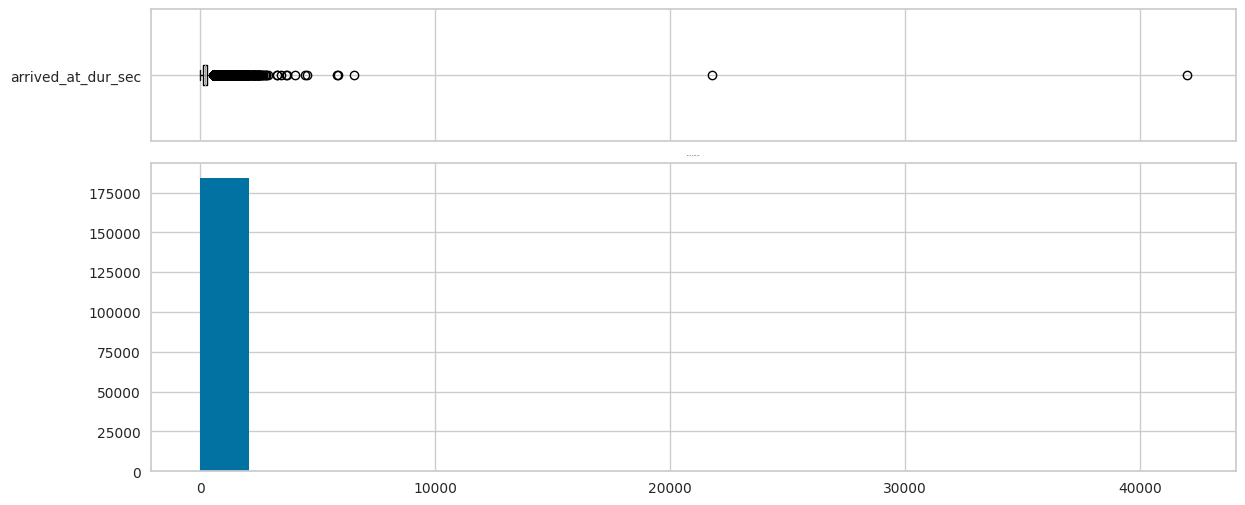

In [38]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="arrived_at_dur_sec",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="arrived_at_dur_sec", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

In [39]:
df['arrived_at_dur_sec'].describe()

count    184209.000000
mean        245.901226
std         217.425548
min           3.000000
25%         125.000000
50%         200.000000
75%         312.000000
max       41966.000000
Name: arrived_at_dur_sec, dtype: float64

<Axes: >

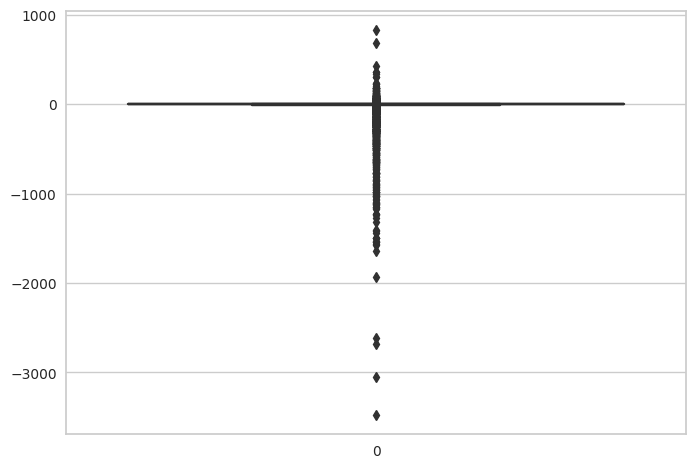

In [40]:
sns.boxplot(data=df['picked_up_at_dur_sec'])

Looks like there is some logging or user error that needs to be taken care of due to negative durations.

In [41]:
# Percentage of neg values
len(df[df['picked_up_at_dur_sec'] <0])/len(df['picked_up_at_dur_sec'])

0.04347778881596447

In [42]:
# Impute with mean to not remove info from other rides

query = """

with cte as (select case when picked_up_at_dur_sec < 0 then NULL else picked_up_at_dur_sec end as picked_up_at_dur_sec2
from df)

, cte2 as (select avg(picked_up_at_dur_sec) as mean_picked_up_dur
from df 
where picked_up_at_dur_sec > 0
)

select case when picked_up_at_dur_sec2 IS NULL then (select mean_picked_up_dur from cte2) else picked_up_at_dur_sec2 end as picked_up_at_dur_sec2
from cte
"""
impute_col2 = duckdb.query(query).df()
impute_col2

,picked_up_at_dur_sec2
0,7.86277
1,3.00000
2,1.00000
3,1.00000
4,2.00000
...,...
184204,7.86277
184205,0.00000
184206,3.00000
184207,7.86277


In [43]:
df['picked_up_at_dur_sec'] = impute_col2

In [44]:
df['picked_up_at_dur_sec'].min()

0.0

<Axes: >

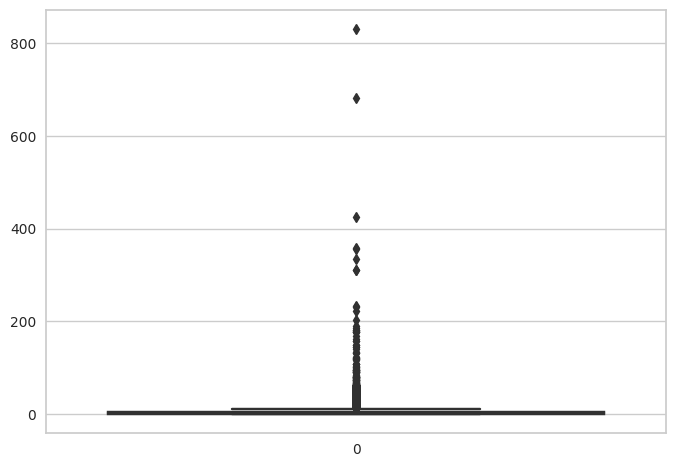

In [45]:
sns.boxplot(data=df['picked_up_at_dur_sec'])

In [46]:
df['picked_up_at_dur_sec'].describe()

count    184209.000000
mean          6.970120
std          13.837191
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max         831.000000
Name: picked_up_at_dur_sec, dtype: float64

## Categorical Data
None that need transformation. 

### Still Cleaning
1. Imputation with mean
* accepted_at_dur_sec, picked_up_at_dur_sec, arrived_at_dur_min
* as well as:  ride_distance, ride_duration, dropped_off_at_dur_min
1. After imputation, transformation for long right tail distribution (left-skewed)
* ride_distance, ride_duration, dropped_off_at_dur_min

#### Imputation
Due to heavy amount of outliers. Other steps for normalization and scaling.

In [47]:
cols = ['ride_distance_mil', 'ride_duration_sec', 'accepted_at_dur_sec', 'arrived_at_dur_sec', 'picked_up_at_dur_sec']

In [48]:
for c in cols:
    print(df[c].describe())

count    184209.000000
mean          4.315567
std           5.553815
min           0.000000
25%           1.526709
50%           2.489834
75%           4.454609
max         450.294515
Name: ride_distance_mil, dtype: float64
count    184209.000000
mean        859.872292
std         572.846146
min           2.000000
25%         492.000000
50%         727.000000
75%        1070.000000
max       28204.000000
Name: ride_duration_sec, dtype: float64
count    184209.000000
mean         11.660608
std          36.515336
min           0.000000
25%           5.000000
50%           6.000000
75%           9.000000
max        5028.000000
Name: accepted_at_dur_sec, dtype: float64
count    184209.000000
mean        245.901226
std         217.425548
min           3.000000
25%         125.000000
50%         200.000000
75%         312.000000
max       41966.000000
Name: arrived_at_dur_sec, dtype: float64
count    184209.000000
mean          6.970120
std          13.837191
min           0.000000
25%      

We can see that there are a lot of outliers. This can be taken care of by determining the meat of the data and with those points outside of the meat of the data, replace it with the mean.

In [49]:
# define lower and upper bounds
# replace anything outside with NaN
# replace null with mean

# Calculate mean and standard deviation

def impute(col):
    mean = df[col].mean()
    std = df[col].std()

    # Calculate the bounds for 3 standard deviations
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    # Calculate the mean of values within the range
    mean_value = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)][col].mean()

    # Replace values within the range with the mean
    df[col] = df[col].apply(lambda x: mean if x < lower_bound or x > upper_bound else x)

    return df

for c in cols:
    impute(c)

### Post-Impute

In [50]:
for c in cols:
    print(df[c].describe())

count    184209.000000
mean          3.778313
std           3.669506
min           0.000000
25%           1.526709
50%           2.489834
75%           4.315567
max          20.976864
Name: ride_distance_mil, dtype: float64
count    184209.000000
mean        818.219569
std         444.775175
min           2.000000
25%         492.000000
50%         727.000000
75%        1040.000000
max        2578.000000
Name: ride_duration_sec, dtype: float64
count    184209.000000
mean          9.523130
std          11.030113
min           0.000000
25%           5.000000
50%           6.000000
75%           9.000000
max         121.000000
Name: accepted_at_dur_sec, dtype: float64
count    184209.000000
mean        235.330085
std         154.372513
min           3.000000
25%         125.000000
50%         200.000000
75%         305.000000
max         898.000000
Name: arrived_at_dur_sec, dtype: float64
count    184209.000000
mean          4.401218
std           6.341939
min           0.000000
25%      

We can definitely see less outliers and the distribution being more compact. Some distribution have remained left skewed, right tail heavy. So let's take a look.

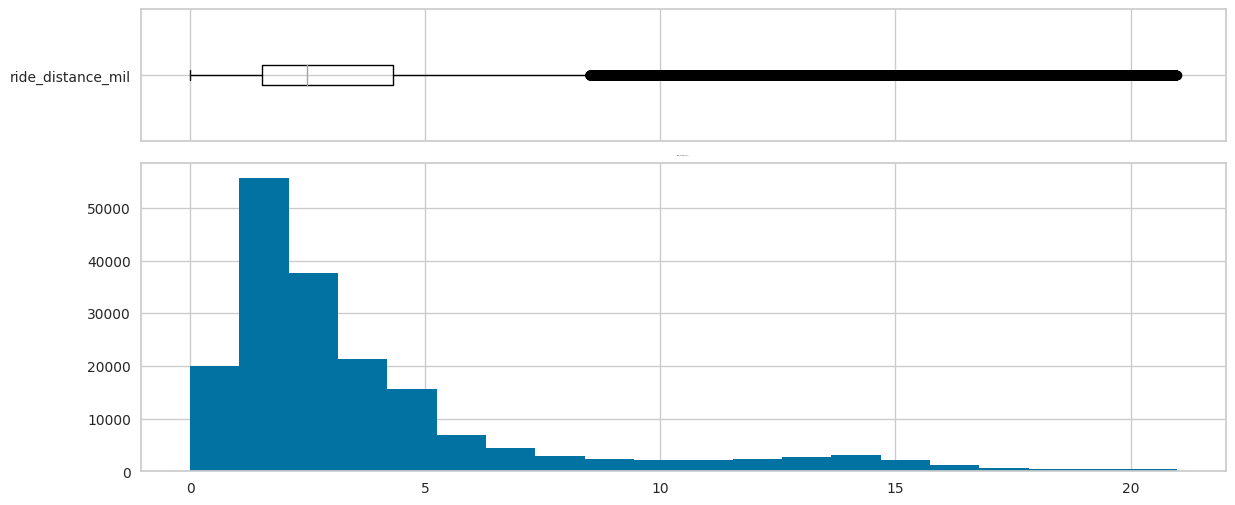

In [51]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="ride_distance_mil",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="ride_distance_mil", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

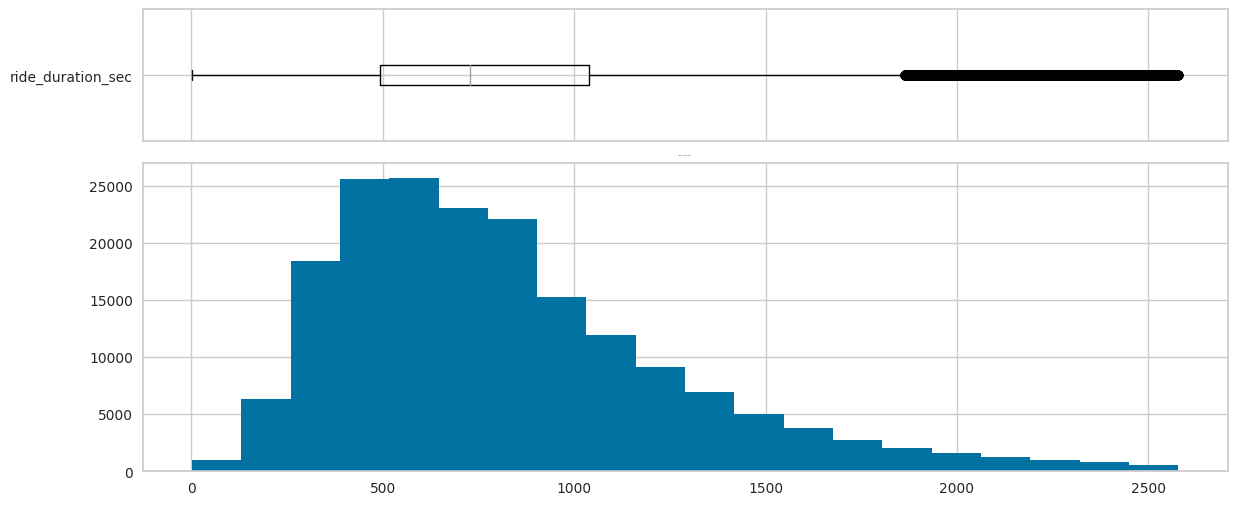

In [52]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="ride_duration_sec",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="ride_duration_sec", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

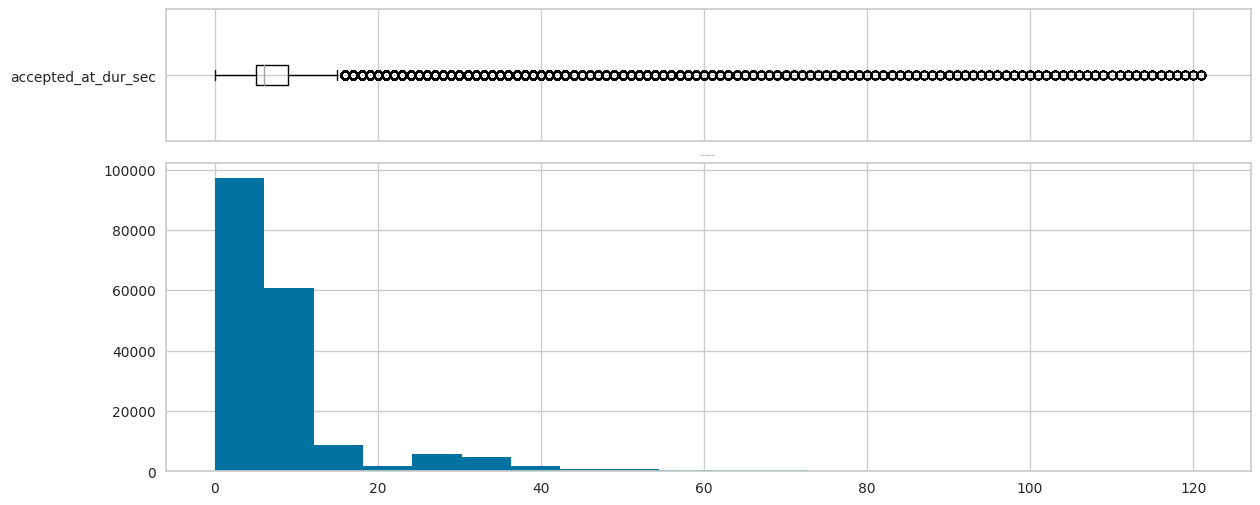

In [53]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="accepted_at_dur_sec",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="accepted_at_dur_sec", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

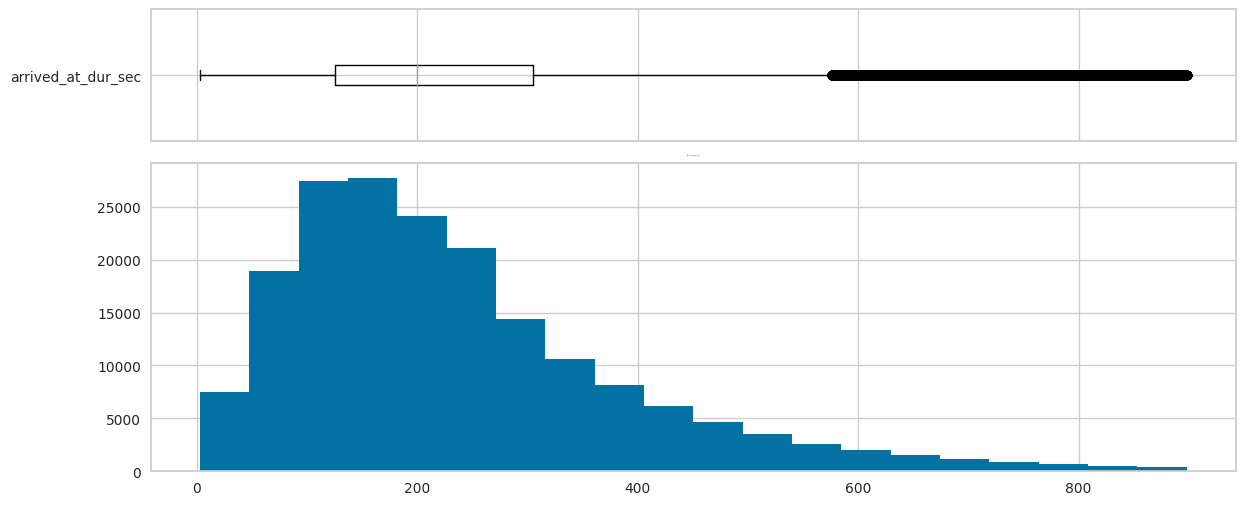

In [54]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="arrived_at_dur_sec",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="arrived_at_dur_sec", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

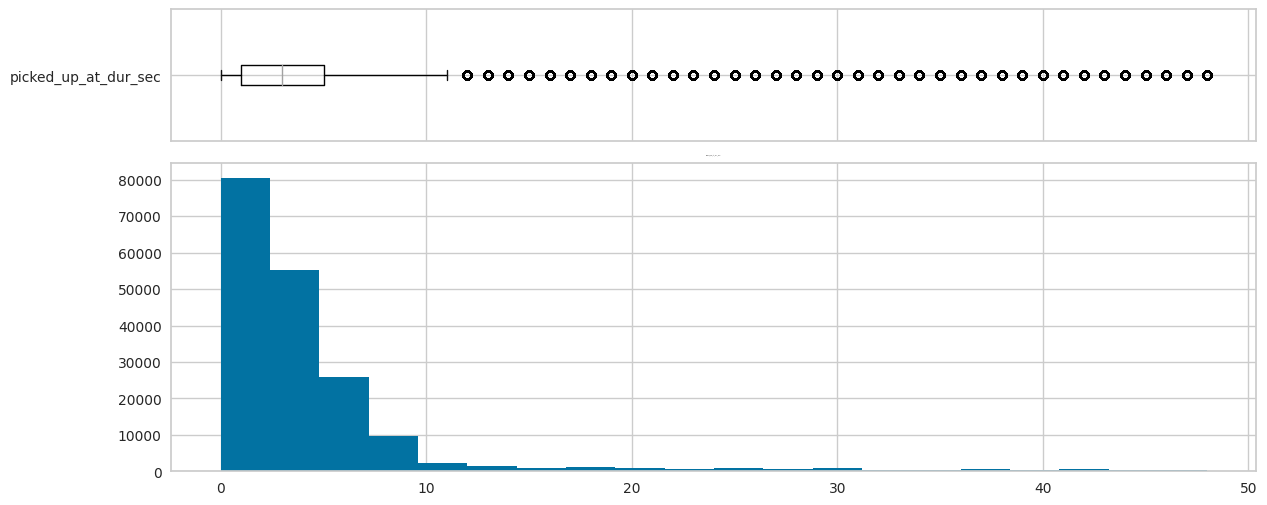

In [55]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df.boxplot(column="picked_up_at_dur_sec",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df.hist(column="picked_up_at_dur_sec", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

# Feature Engineering
For date parts, remember to keep in mind that data spans only couple of months. 

In [56]:
# Add date parts
query = """
select *

, date_part('hour', accepted_at_ts) as accepted_at_hour
, date_part('dayofweek', accepted_at_ts) as accepted_at_dow
, date_part('week', accepted_at_ts) as accepted_at_week
, date_part('month', accepted_at_ts) as accepted_at_month

, date_diff('minute', accepted_at_ts, arrived_at_ts) as time_to_arrive
, date_diff('minute', picked_up_at_ts, dropped_off_at_ts) as time_to_drop_off


from df
"""

df_feat = duckdb.query(query).df()
df_feat.head(2)

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_day,driver_onboard_week,ride_id,ride_distance,ride_prime_time,requested_at_ts,accepted_at_ts,...,ride_duration_sec,accepted_at_dur_sec,arrived_at_dur_sec,picked_up_at_dur_sec,accepted_at_hour,accepted_at_dow,accepted_at_week,accepted_at_month,time_to_arrive,time_to_drop_off
0,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,d1f12354ce9bf47223b43c5735e3e9bd,2682,0,2016-04-20 14:24:19,2016-04-20 14:24:23,...,370.0,4.0,631.0,7.86277,14,3,16,4,10,7
1,7c4bcea05c14431c65ef1d9cfa20ecb1,2016-03-31,3,31,13,daa6e7e938dad5f14be37d5c44006a11,19488,0,2016-04-06 18:53:36,2016-04-06 18:53:41,...,1738.0,5.0,584.0,3.00000,18,3,14,4,10,29


In [57]:
# Total rides per driver

query = """

select *
, count(ride_id) over (partition by driver_id) as ride_count
from df_feat 
"""
df_feat = duckdb.query(query).df()

In [58]:
# Total fare per ride

# Computing fare, we use guidance from Lyft's rate card:
# Fare = (base fare + cost per mile miles traveled + cost per minute mins traveled)(1 + prime time/100) + service fee
# = 2 + 1.15 miles traveled + 0.22 mins traveled)(1 + prime time/100) + 1.75
# After calculating fare, need to ensure that all fares are with lower bound of 5 USD and upper bound of 400 USD.

# Fare

# convert ride_duration from seconds to minutes
df_feat['ride_duration_min'] = df_feat['ride_duration_sec']/60

query = """
with fare_sub as (
select *
, ((2 + 1.15*ride_distance_mil + 0.22*ride_duration_min)*(1 + ride_prime_time)) + 1.75
as fares
from df_feat
)

select *
, case when fares < 5.0 then 5.0 
when fares > 400.0 then 400.0
else fares
end as fare
from fare_sub
"""

df_feat = duckdb.query(query).df()
df_feat.drop(columns=['ride_duration_min', 'fares'], inplace=True)
df_feat.head(2)

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_day,driver_onboard_week,ride_id,ride_distance,ride_prime_time,requested_at_ts,accepted_at_ts,...,arrived_at_dur_sec,picked_up_at_dur_sec,accepted_at_hour,accepted_at_dow,accepted_at_week,accepted_at_month,time_to_arrive,time_to_drop_off,ride_count,fare
0,04d686ef2fba281e395992a28f14fdd3,2016-05-14,5,14,19,ac54520015fcb545504ca45b9591c0c3,3654,0,2016-06-06 05:47:40,2016-06-06 05:47:44,...,191.0,2.0,5,1,23,6,3,10,318,8.473063
1,04d686ef2fba281e395992a28f14fdd3,2016-05-14,5,14,19,b490f92c37edde1c0bf1c7edb667a502,1317,0,2016-06-07 11:27:32,2016-06-07 11:27:36,...,210.0,1.0,11,2,23,6,4,9,318,6.759097


In [59]:
# Total fare per driver

query = """

select *
, sum(fare) over (partition by driver_id) as driver_income
from df_feat

"""

df_feat = duckdb.query(query).df()
df_feat.head(2)

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_day,driver_onboard_week,ride_id,ride_distance,ride_prime_time,requested_at_ts,accepted_at_ts,...,picked_up_at_dur_sec,accepted_at_hour,accepted_at_dow,accepted_at_week,accepted_at_month,time_to_arrive,time_to_drop_off,ride_count,fare,driver_income
0,02e440f6c209206375833cef02e0cbae,2016-03-31,3,31,13,3e85e601f38c01b1a2af685c81f7cb9d,3961,0,2016-04-26 07:21:53,2016-04-26 07:22:22,...,4.0,7,2,17,4,6,9,56,8.575105,4811.609255
1,02e440f6c209206375833cef02e0cbae,2016-03-31,3,31,13,08c9bbdf66d8eb6db69a3893fa819985,5156,0,2016-04-19 19:31:14,2016-04-19 19:31:29,...,2.0,19,2,16,4,4,21,56,11.988357,4811.609255


In [60]:
# Create is_weekday flag to filter out possible part-time weekend drivers

query = """
select *
, case when accepted_at_dow not in (0,6) then 1 else 0 end as is_weekday
from df_feat
"""

df_feat = duckdb.query(query).df()
df_feat.head(2)

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_day,driver_onboard_week,ride_id,ride_distance,ride_prime_time,requested_at_ts,accepted_at_ts,...,accepted_at_hour,accepted_at_dow,accepted_at_week,accepted_at_month,time_to_arrive,time_to_drop_off,ride_count,fare,driver_income,is_weekday
0,02e440f6c209206375833cef02e0cbae,2016-03-31,3,31,13,3e85e601f38c01b1a2af685c81f7cb9d,3961,0,2016-04-26 07:21:53,2016-04-26 07:22:22,...,7,2,17,4,6,9,56,8.575105,4811.609255,1
1,02e440f6c209206375833cef02e0cbae,2016-03-31,3,31,13,08c9bbdf66d8eb6db69a3893fa819985,5156,0,2016-04-19 19:31:14,2016-04-19 19:31:29,...,19,2,16,4,4,21,56,11.988357,4811.609255,1


In [61]:
# Flag for drivers who drive late (11 PM PST- 6 AM PST or between 6 and 23; since timestamps in UTC (7 hours ahead of SF (PST)): between 6 and 13

query = """
select *
, case when accepted_at_hour between 6 and 13 then 1 else 0 end as is_late_ride
from df_feat
"""

df_feat = duckdb.query(query).df()
df_feat.head(2)

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_day,driver_onboard_week,ride_id,ride_distance,ride_prime_time,requested_at_ts,accepted_at_ts,...,accepted_at_dow,accepted_at_week,accepted_at_month,time_to_arrive,time_to_drop_off,ride_count,fare,driver_income,is_weekday,is_late_ride
0,02e440f6c209206375833cef02e0cbae,2016-03-31,3,31,13,3e85e601f38c01b1a2af685c81f7cb9d,3961,0,2016-04-26 07:21:53,2016-04-26 07:22:22,...,2,17,4,6,9,56,8.575105,4811.609255,1,1
1,02e440f6c209206375833cef02e0cbae,2016-03-31,3,31,13,08c9bbdf66d8eb6db69a3893fa819985,5156,0,2016-04-19 19:31:14,2016-04-19 19:31:29,...,2,16,4,4,21,56,11.988357,4811.609255,1,0


In [62]:
# Compute how long it takes for driver to pick up next ride 
# Caluclate time between dropped_off_at from ride 1 to accepted_at from ride 2

In [63]:
# Compute how long it takes for driver to pick up next ride 
# Caluclate time between dropped_off_at from ride 1 to accepted_at from ride 2

# order rides in asc order by driver_id
# condition when dropped_off and accept_at in same month and same day then calculate difference in minutes (only considering back-to-back rides)

query = """
with next_ride as (
select *
, lead(accepted_at_ts, 1) over (partition by driver_id order by accepted_at_ts) as next_ride_acc
from df_feat
)

select *
, case when extract(month from dropped_off_at_ts) = extract(month from next_ride_acc) and extract(day from dropped_off_at_ts) = extract(day from next_ride_acc) then date_diff('minute', dropped_off_at_ts, next_ride_acc) else null end as next_ride_lag
from next_ride
"""

df_feat = duckdb.query(query).df()
df_feat.drop(columns=['next_ride_acc'], inplace=True)
df_feat.head(2)

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_day,driver_onboard_week,ride_id,ride_distance,ride_prime_time,requested_at_ts,accepted_at_ts,...,accepted_at_week,accepted_at_month,time_to_arrive,time_to_drop_off,ride_count,fare,driver_income,is_weekday,is_late_ride,next_ride_lag
0,fffecccc49436c5389075b13209f0dfa,2016-05-06,5,6,18,ecdaa02e4adf30dbce1f69bfa075d07a,21901,0,2016-06-07 04:30:29,2016-06-07 04:30:33,...,23,6,4,19,406,23.451610,68024.867865,1,0,19.0
1,fffecccc49436c5389075b13209f0dfa,2016-05-06,5,6,18,7d2b8dced2356f1e6316e9e5cbf86195,23186,0,2016-06-07 05:12:51,2016-06-07 05:12:55,...,23,6,2,21,406,25.029841,68024.867865,1,0,15.0


In [64]:
# Calculate unique days drivers drove

# get date part from accepted_at
# count distinct accepted_at date partitioned by driver_id for total unique driving days

df_feat['accepted_at_date'] = df_feat['accepted_at_ts'].dt.date
df_feat['accepted_at_date'].head(2)

0    2016-06-07
1    2016-06-07
Name: accepted_at_date, dtype: object

In [65]:
query = """
select *
, dense_rank() over (partition by driver_id order by accepted_at_date) 
+ dense_rank() over (partition by driver_id order by accepted_at_date desc) 
- 1 as unique_drive_days
from df_feat
"""

df_feat = duckdb.query(query).df()
duckdb.query('select driver_id, accepted_at_date, unique_drive_days from df_feat order by driver_id, accepted_at_date').df()

,driver_id,accepted_at_date,unique_drive_days
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
1,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
2,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
3,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
4,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
...,...,...,...
184204,ffff51a71f2f185ec5e97d59dbcd7a78,2016-06-25,38
184205,ffff51a71f2f185ec5e97d59dbcd7a78,2016-06-25,38
184206,ffff51a71f2f185ec5e97d59dbcd7a78,2016-06-25,38
184207,ffff51a71f2f185ec5e97d59dbcd7a78,2016-06-26,38


In [66]:
# total driving period (calculated earlier but adding to main table)
query = """
with drive_seq as (
select *
, row_number() over (partition by driver_id order by accepted_at_ts desc) as drive_acc_rev_order
from df_feat
)

select  *
, case when drive_acc_rev_order = 1 then datediff('day', driver_onboard_date,  accepted_at_ts) else NULL end as driving_period
from drive_seq
"""

df_feat = duckdb.query(query).df()
df_feat.head(5)

,driver_id,driver_onboard_date,driver_onboard_month,driver_onboard_day,driver_onboard_week,ride_id,ride_distance,ride_prime_time,requested_at_ts,accepted_at_ts,...,ride_count,fare,driver_income,is_weekday,is_late_ride,next_ride_lag,accepted_at_date,unique_drive_days,drive_acc_rev_order,driving_period
0,647bd8b8b02c285db177096a351f8e2c,2016-04-12,4,12,15,b3a732cde597ac6a6f3c8c3072d9e4ac,10204,0,2016-04-14 12:06:35,2016-04-14 12:06:54,...,34,14.378207,2594.453408,1,1,19.0,2016-04-14,6,31,NaN
1,647bd8b8b02c285db177096a351f8e2c,2016-04-12,4,12,15,a6c625604e4ea37c94694f441e2cf9d1,3369,0,2016-04-14 11:35:31,2016-04-14 11:35:42,...,34,9.534409,2594.453408,1,1,10.0,2016-04-14,6,32,NaN
2,647bd8b8b02c285db177096a351f8e2c,2016-04-12,4,12,15,7f306fec09b1956b04baada3073c533a,4081,0,2016-04-12 17:18:30,2016-04-12 17:18:38,...,34,9.287854,2594.453408,1,0,NaN,2016-04-12,6,33,NaN
3,647bd8b8b02c285db177096a351f8e2c,2016-04-12,4,12,15,f4d6cb5e6d3fa49ec8a761c5febfbc5e,2737,0,2016-04-12 16:48:15,2016-04-12 16:48:39,...,34,7.146796,2594.453408,1,0,10.0,2016-04-12,6,34,NaN
4,64e245c2e3f5c7658bc062e9840c04dc,2016-05-06,5,6,18,adf45cba5cceed53b34ae4a14e962590,2935,50,2016-06-19 20:15:55,2016-06-19 20:15:56,...,379,301.032406,56534.915033,0,0,NaN,2016-06-19,39,1,44.0


In [67]:
df_feat.drop(columns=['accepted_at_date'], inplace=True)

### Target Variables

#### Churn - Logistic Regression

Defining churn:
* get last ride timestamp
* see if any driver has not had a ride within 7 days
* if so, these are inactive/churned drivers

In [68]:
# Last accepted ride from driver given dataset's snapshot of activity
df_feat['accepted_at_ts'].max()

Timestamp('2016-06-26 23:57:49')

In [69]:
# Get days since last accepted ride record

query = """

select *
, case when drive_acc_rev_order = 1 then datediff('day', accepted_at_ts, TIMESTAMP '2016-06-26 23:57:49') else NULL end as last_activity
from df_feat

"""

df_feat = duckdb.query(query).df()
duckdb.query('select driver_id, accepted_at_ts, drive_acc_rev_order, last_activity from df_feat order by last_activity desc limit 20').df()

,driver_id,accepted_at_ts,drive_acc_rev_order,last_activity
0,bd057e02f75c92917389d90bb215fe91,2016-03-30 18:50:54,1,88.0
1,6eb2e0f41fc9f1fbb70e7751035fdf87,2016-03-30 17:36:24,1,88.0
2,e4f3a9d5cf57b9b518136afd9757f76d,2016-03-31 10:06:46,1,87.0
3,68b546b2f4102641d6774c1ce4f57457,2016-03-31 19:17:05,1,87.0
4,9fa4b644d8b6ea510119808c37f22223,2016-04-05 22:47:38,1,82.0
5,1110d496149d3d8c50276765924df831,2016-04-07 12:27:44,1,80.0
6,b8df3a1ffca045016321353536ac86cf,2016-04-07 23:32:03,1,80.0
7,9835cfed2c02bee16b5f0eeac3b4926a,2016-04-08 06:55:25,1,79.0
8,3b2dca5cc3db92a05ea35056887108b6,2016-04-09 20:52:22,1,78.0
9,84e1a98ccf46774bc4f5c6374079dc07,2016-04-10 00:27:31,1,77.0


In [70]:
df_feat.drop(columns=['drive_acc_rev_order'], inplace=True)

In [71]:
# Creating churn flag

query = """

select *
, case when last_activity >7 then 1 else 0 end as churn
from df_feat

"""

df_feat = duckdb.query(query).df()
df_feat['churn'].value_counts()

churn
0    183904
1       305
Name: count, dtype: int64

#### LTV - Linear Regression

Calculate LTV
To calculate LTV, referred to https://blog.hubspot.com/service/how-to-calculate-customer-lifetime-value.

Define the variables as follows:

LTV = (Avg Income Generated by Driver/Churn Rate) * 365

Avg Income Generated by Driver = Total Income Generated by Driver /Number of Days Driver Drove

Churn Rate = (Number of Drivers Who Have Stopped Driving/Total Number of Drivers) * 100%

In [72]:
# Churn Perc

query = """

select round(sum(churn)/count(distinct driver_id)*100.0, 2) as churn_perc
from df_feat

"""

churn_perc = duckdb.query(query).df()
churn_perc

,churn_perc
0,36.44


In [73]:
# Churn Rate
churn_rate = len(df_feat[df_feat['churn'] == 1]) / df_feat['driver_id'].nunique()
churn_rate

0.3643966547192354

## What is the average projected lifetime of a driver?
That is, once a driver is onboarded, how long do they typically continue driving with Lyft?

In [74]:
### Average Lifetime of a driver is inverse of churn rate.
print('Average lifetime of driver: ', 1/churn_rate, 'years.')

Average lifetime of driver:  2.7442622950819673 years.


Recommended Driver's Lifetime Value
value of a driver to Lyft over the entire projected lifetime of a driver

Equation:
Assumptions: 3 months of data is enough to define LTV.

## Predictive Indicators of Churn and LTV

In [75]:
# Need to aggregated/fold up table to driver level to look at churn/LTV predictive behaviors

query = """
select driver_id
, driver_onboard_month
, driver_onboard_day
, driver_onboard_week
, avg(ride_distance_mil) as avg_ride_distance_mil
, avg(ride_duration_sec) as avg_ride_duration_sec

, mode(accepted_at_hour) as most_accepted_at_hour

, mode(accepted_at_dow) as most_accepted_at_dow
, mode(accepted_at_week) as most_accepted_at_week
, mode(accepted_at_month) as most_accepted_at_month

, avg(time_to_arrive) as avg_time_to_arrive
, avg(time_to_drop_off) as avg_time_to_drop_off

, ride_count
, avg(fare) as avg_ride_fare
, driver_income
, mode(is_weekday) as weekday_driver
, mode(is_late_ride) as evening_driver
, avg(next_ride_lag) as avg_next_ride_lag
, unique_drive_days
, avg(driving_period) as avg_driving_period
, avg(last_activity) as avg_dormant_days
, sum(churn) as churn

from df_feat

group by all
"""
df_driver = duckdb.query(query).df()
df_driver.head()

,driver_id,driver_onboard_month,driver_onboard_day,driver_onboard_week,avg_ride_distance_mil,avg_ride_duration_sec,most_accepted_at_hour,most_accepted_at_dow,most_accepted_at_week,most_accepted_at_month,...,ride_count,avg_ride_fare,driver_income,weekday_driver,evening_driver,avg_next_ride_lag,unique_drive_days,avg_driving_period,avg_dormant_days,churn
0,b972617c1e490250b2dbcd3353fd436b,4,8,14,4.282156,864.750000,0,5,15,4,...,28,38.586040,1080.409126,1,0,87.888889,10,70.0,9.0,1.0
1,e0a98706329350c48ea450d1705bdd86,4,4,14,3.802590,768.676798,14,1,25,5,...,504,63.006212,31755.130941,1,0,52.155056,66,83.0,0.0,0.0
2,f2a9db857bbd5fe385ed59d8f2e89621,4,23,16,3.934882,747.462697,7,1,21,5,...,312,92.867474,28974.651821,1,1,28.328467,38,61.0,3.0,0.0
3,0b10af0ede0648dbe6ae05813c5cbf1b,5,13,19,3.217169,633.710526,23,5,19,5,...,38,107.508584,4085.326200,1,0,24.156250,8,28.0,16.0,1.0
4,0eff1404b137a5562642f0f706e59f25,3,29,13,3.264808,663.266667,18,5,13,4,...,45,45.077821,2028.501967,1,0,75.742857,11,22.0,67.0,1.0


In [76]:
df_driver['average_ride_val'] = df_driver['avg_ride_fare'] / df_driver['ride_count']

df_driver['average_ride_freq'] = df_driver['ride_count'] / df_driver['unique_drive_days']

df_driver['average_val'] = df_driver['average_ride_val'] * df_driver['average_ride_freq']

df_driver['ltv'] = df_driver['average_val'] * 365 / churn_rate

Side note: Extra data that would be nice to help define drivers' LTV:

1. CAC - cost per acquired driver
1. how is revenue distributed in city (cost areas)

In [77]:
df_driver.to_csv('df_driver.csv', index=False)

In [78]:
df_driver.head()

,driver_id,driver_onboard_month,driver_onboard_day,driver_onboard_week,avg_ride_distance_mil,avg_ride_duration_sec,most_accepted_at_hour,most_accepted_at_dow,most_accepted_at_week,most_accepted_at_month,...,evening_driver,avg_next_ride_lag,unique_drive_days,avg_driving_period,avg_dormant_days,churn,average_ride_val,average_ride_freq,average_val,ltv
0,b972617c1e490250b2dbcd3353fd436b,4,8,14,4.282156,864.750000,0,5,15,4,...,0,87.888889,10,70.0,9.0,1.0,1.378073,2.800000,3.858604,3864.992858
1,e0a98706329350c48ea450d1705bdd86,4,4,14,3.802590,768.676798,14,1,25,5,...,0,52.155056,66,83.0,0.0,0.0,0.125012,7.636364,0.954640,956.220211
2,f2a9db857bbd5fe385ed59d8f2e89621,4,23,16,3.934882,747.462697,7,1,21,5,...,1,28.328467,38,61.0,3.0,0.0,0.297652,8.210526,2.443881,2447.927315
3,0b10af0ede0648dbe6ae05813c5cbf1b,5,13,19,3.217169,633.710526,23,5,19,5,...,0,24.156250,8,28.0,16.0,1.0,2.829173,4.750000,13.438573,13460.823780
4,0eff1404b137a5562642f0f706e59f25,3,29,13,3.264808,663.266667,18,5,13,4,...,0,75.742857,11,22.0,67.0,1.0,1.001729,4.090909,4.097984,4104.768959


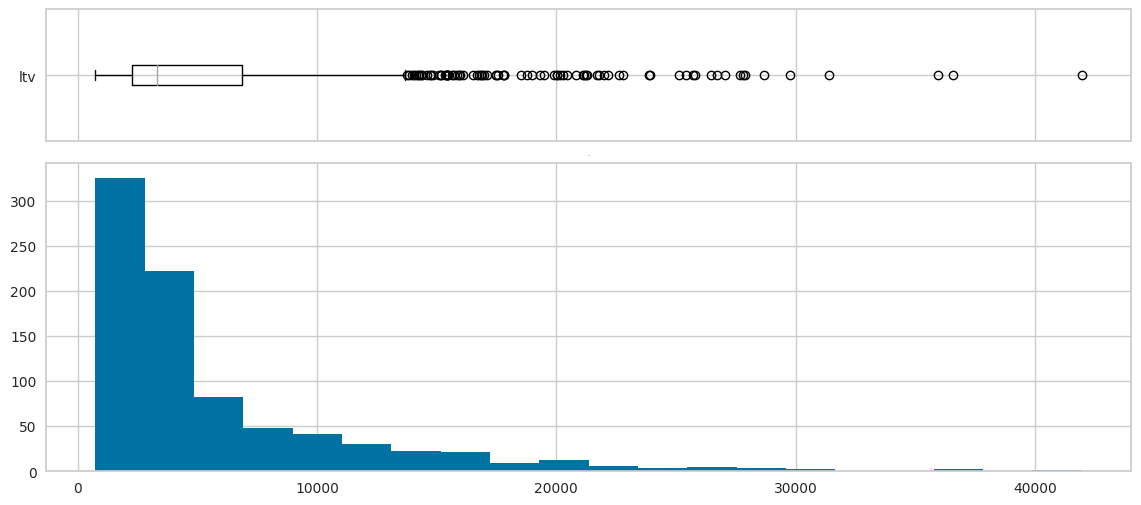

In [79]:
# LTV distribution
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, # Common x-axis
                       gridspec_kw={"height_ratios": (.3, .7)})  # boxplot 30% of the vertical space

#Boxplot
df_driver.boxplot(column="ltv",vert=False,figsize=(14,6), ax=ax[0])
#Histogram
df_driver.hist(column="ltv", bins=20, figsize=(14,6), ax=ax[1])
ax[1].title.set_size(0)
plt.subplots_adjust(hspace=0.1) ##Adjust gap between the two plots

In [80]:
df_driver['ltv'].describe()

count      837.000000
mean      5737.817130
std       5711.644303
min        739.767698
25%       2285.778263
50%       3323.401801
75%       6856.486148
max      41956.694464
Name: ltv, dtype: float64

# Unsupervised Learning
Reference: https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering

# ** Need to do segmentation for CHURNed drivers as well

# Do some Bivariate Analysis (Correlation/Covariance)

<Axes: >

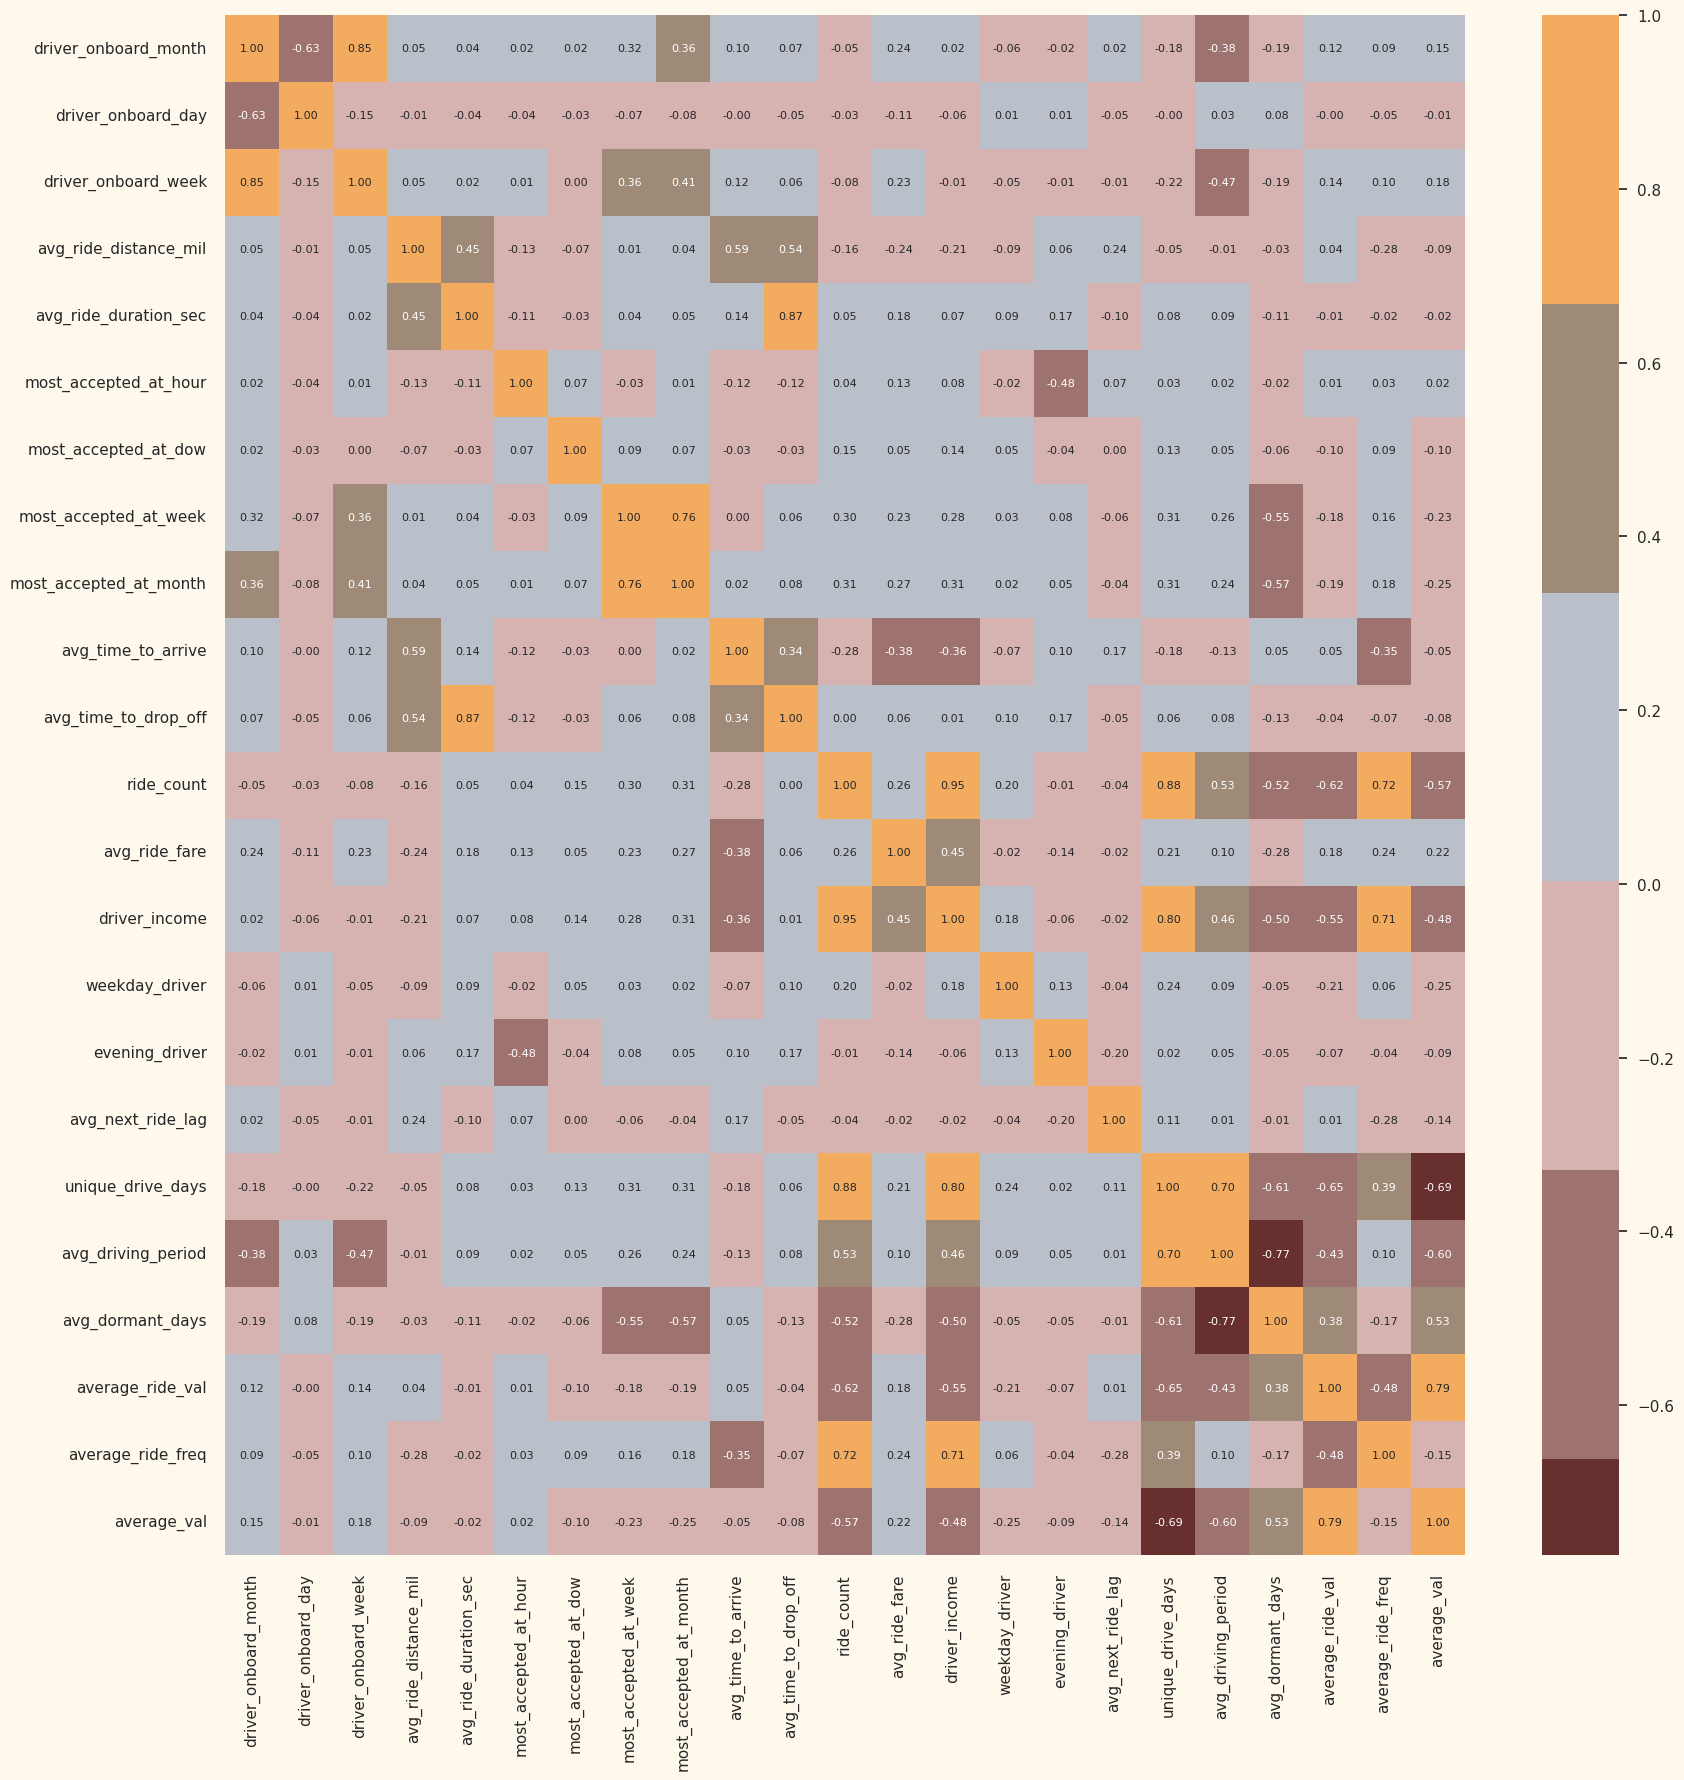

In [81]:
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#correlation matrix
df_bivar = df_driver.drop(columns=['driver_id', 'churn', 'ltv'])

# Calculate the Pearson correlation matrix

corr_matrix = df_bivar.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corr_matrix,annot=True, cmap=cmap, fmt=".2f", annot_kws={"size": 8}, center=0)

Most of the high values (close to 1) are on the diagonal or are derivatives of each other.

In [82]:
df_bivar.isnull().sum()

driver_onboard_month      0
driver_onboard_day        0
driver_onboard_week       0
avg_ride_distance_mil     0
avg_ride_duration_sec     0
most_accepted_at_hour     0
most_accepted_at_dow      0
most_accepted_at_week     0
most_accepted_at_month    0
avg_time_to_arrive        0
avg_time_to_drop_off      0
ride_count                0
avg_ride_fare             0
driver_income             0
weekday_driver            0
evening_driver            0
avg_next_ride_lag         1
unique_drive_days         0
avg_driving_period        0
avg_dormant_days          0
average_ride_val          0
average_ride_freq         0
average_val               0
dtype: int64

In [83]:
# Get rid of null
df_bivar.dropna(inplace=True)

In [84]:
# Scaling

scaler = StandardScaler()
scaler.fit(df_bivar)
scaled_df = pd.DataFrame(scaler.transform(df_bivar),columns= df_bivar.columns )
print("All features are now scaled")

All features are now scaled


In [85]:
# Scaling for Churned Drivers

scaler = StandardScaler()
scaler.fit(df_bivar)
scaled_df = pd.DataFrame(scaler.transform(df_bivar),columns= df_bivar.columns )
print("All features are now scaled")

All features are now scaled


# PCA
Make sure all same type data (time) is in the same units

In [86]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_df)
PCA_df = pd.DataFrame(pca.transform(scaled_df), columns=(["col1","col2", "col3"]))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,836.0,-4.674623e-17,2.369272,-5.859189,-2.182557,0.800130,1.776269,6.143482
col2,836.0,3.399726e-17,1.741486,-5.197635,-0.935133,-0.161582,1.294351,5.607499
col3,836.0,-5.099589e-17,1.682437,-5.055162,-1.083599,-0.123828,1.006582,7.663433


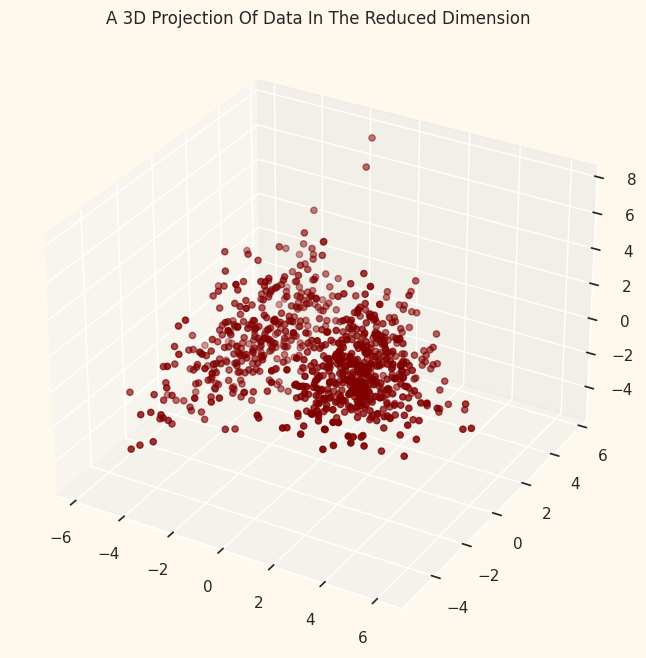

In [87]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_df["col1"]
y =PCA_df["col2"]
z =PCA_df["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Clustering (K-Means and Hierarchical)/Customer Segmentation

Elbow Method to determine the number of clusters to be formed:


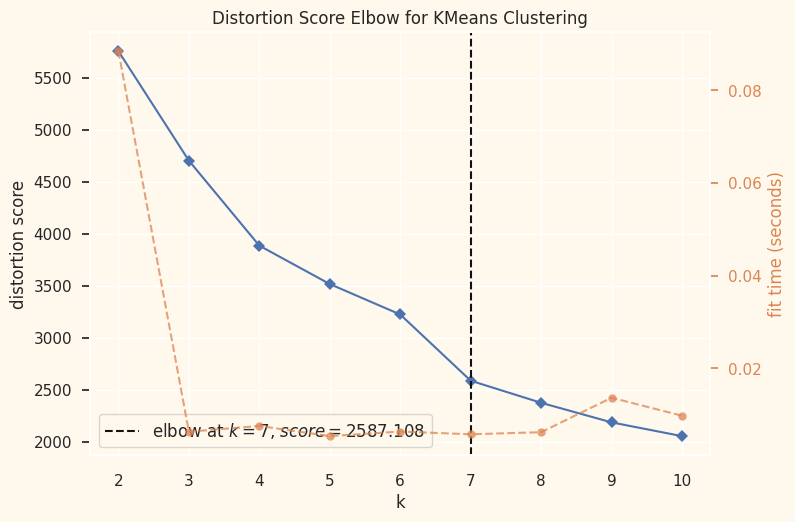

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [88]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_df)
Elbow_M.show()

Looks like 5 is the optimal number of clusters.

In [89]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_df)
PCA_df["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df_bivar["Clusters"]= yhat_AC

3-D Distribution of Clusters

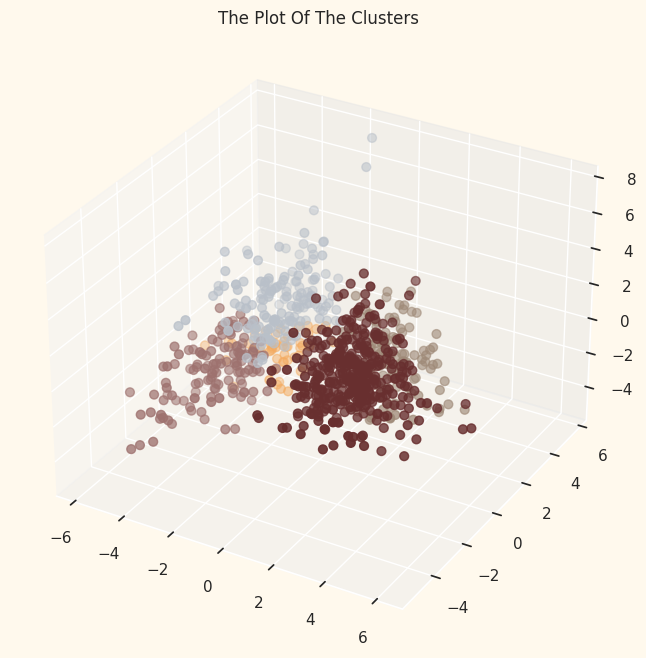

In [90]:
#Plotting the clusters
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

# Evaluating Models

The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

First, let us take a look a the distribution of drivers in each cluster.

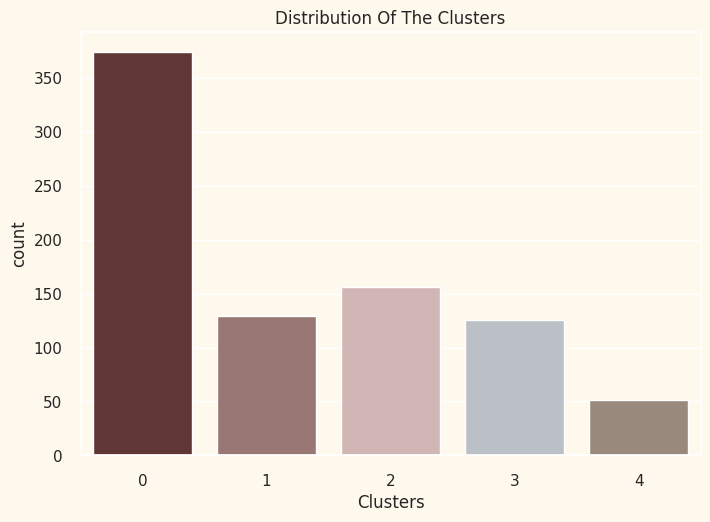

In [91]:
#Plotting countplot of clusters
pal = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78"]

pl = sns.countplot(x=df_bivar["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

Clusters 0 and 4 are the largest.

Let's examine some interesting relationships with some driver behavior.

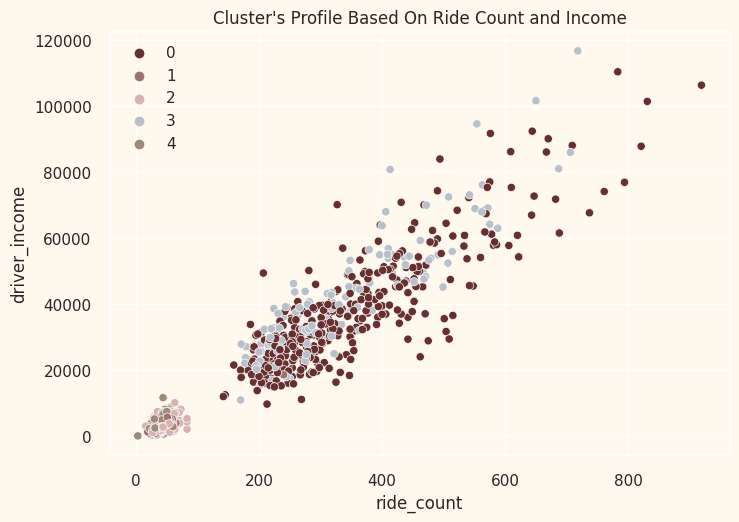

In [92]:
# total rides accepted x total income

pl = sns.scatterplot(data = df_bivar,x=df_bivar["ride_count"], y=df_bivar["driver_income"],hue=df_bivar["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Ride Count and Income")
plt.legend()
plt.show()

Very linear relationship, but does not mean causation. Though the relationship loses its tightness towards the larger ride counts that have more variance in income per total rides. 

* group 0: on lower side of ride count, lower side of income
* group 1: broad range as well along with income
* group 2: broad range of rides but not at the most top, so with income
* group 3: covers almost whole range of rides and income
* group 4: mostly mid-range as well as with income

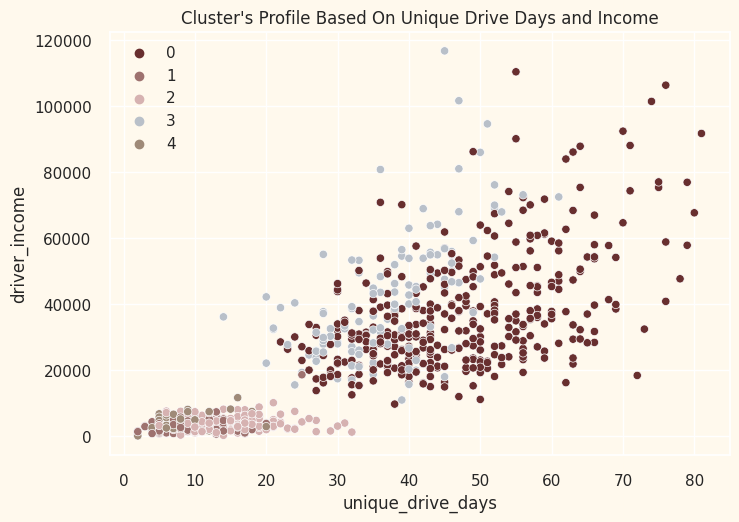

In [93]:
# total unique drive days with accepted rides x total income

pl = sns.scatterplot(data = df_bivar,x=df_bivar["unique_drive_days"], y=df_bivar["driver_income"],hue=df_bivar["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Unique Drive Days and Income")
plt.legend()
plt.show()

The number of distinct drive days has not as strong correlation with income.

This is interesting. For a month of driving, there is a cap in income...across mostly groups 0 and 2. I am curious if in the algorithm, higher ride fares are given to higher tenured drivers. Groups 3 and 4 are the most tenured. Most are 2 month tenures.

* group 0: a lot of driving for a month only that have low income
* group 1: mid range driving days as well as income
* group 2: a lot of driving for a month only that have low income
* group 3: some driving for a month only that have low income, very broad range of days driving to income made
* group 4: broad range of days driving to income made

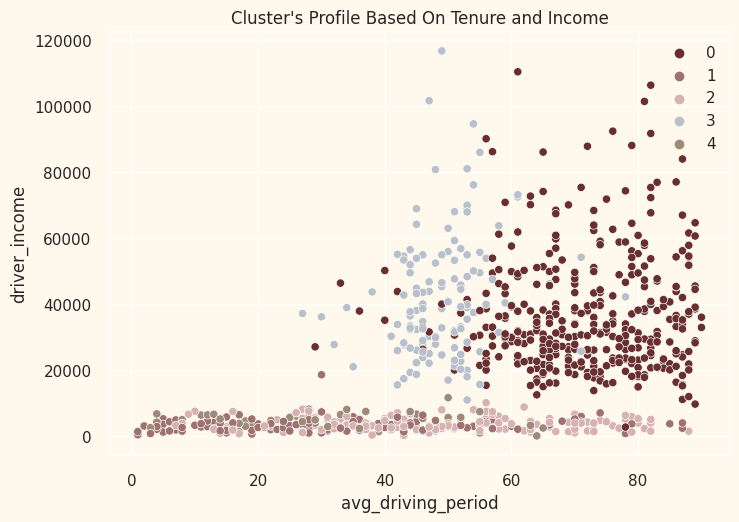

In [94]:
# tenure x total income

pl = sns.scatterplot(data = df_bivar,x=df_bivar["avg_driving_period"], y=df_bivar["driver_income"],hue=df_bivar["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Tenure and Income")
plt.legend()
plt.show()

Tenure is the least correlated with income.
We see here that tenure is not a distinguishing factor for groups 0 and 2. 

* group 0: regardless of tenure, income at all ranges
* group 1: higher tenure (> 1 month), average income
* group 2: tenure at across whole 3 month snapshot, but mostly at high end as well, income across whole range
* group 3:  higher tenure, average to high income
* group 4: higher tenure, middle to high income

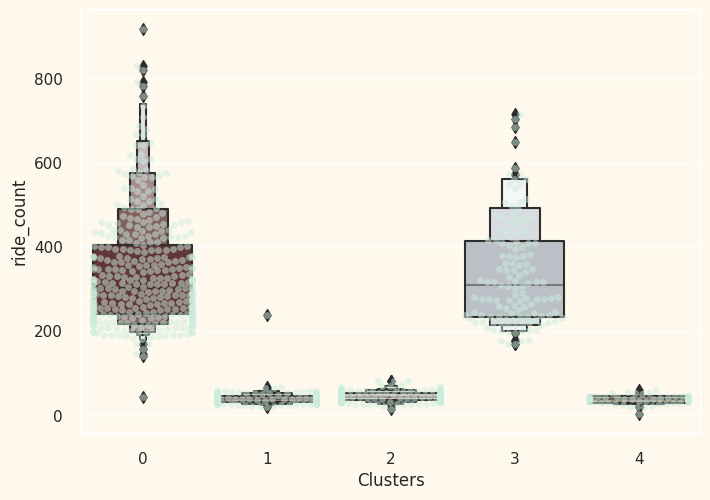

In [95]:
plt.figure()
pl=sns.swarmplot(x=df_bivar["Clusters"], y=df_bivar["ride_count"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df_bivar["Clusters"], y=df_bivar["ride_count"], palette=pal)
plt.show()

Groups 1-4 all seem of equivalent size. Let us see what sort of rides each cluster consists of.

Strategic way to go about this is to look at what drivers are offered before accepting rides and see how each group differs in preference based on those factors:

* Fare: The amount the driver will earn 
* Route: A map of the entire trip 
* Distance: The estimated distance of the ride 
* Time: The estimated time to complete the ride 
* Pick-up and drop-off locations: The approximate locations 
* Rider rating: The rider's rating 

Then based on these difference preferences, make sure the right sort of combination of these is presented to each group.

In [96]:
df_bivar['avg_ride_fare'].describe() # create new feature: lowest_fare, low_fare, medium_fare, high_fare

count    836.000000
mean     103.660734
std       34.126635
min       11.655648
25%       81.550734
50%      105.814791
75%      123.494913
max      266.429835
Name: avg_ride_fare, dtype: float64

In [97]:
#Creating a feature to get average fare levels
def fare_level(fare):
    if fare < 82:
        return 'Lowest'
    if fare >= 82 and fare <= 106:
        return 'Low'
    if fare >= 107 and fare <= 124:
        return 'Medium'
    return 'High'
df_bivar['fare_level'] = df_bivar['avg_ride_fare'].apply(fare_level)

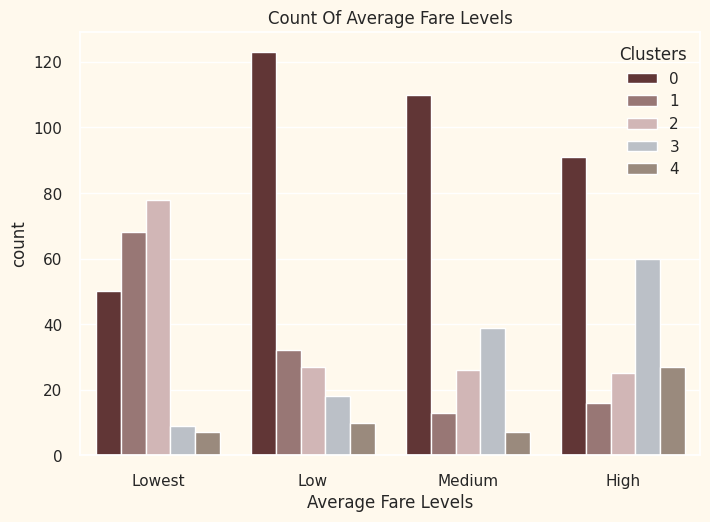

In [98]:
#Plotting count of average fare levels.
plt.figure()
pl = sns.countplot(x=df_bivar["fare_level"],hue=df_bivar["Clusters"], order = ['Lowest', 'Low', 'Medium', 'High'], palette= pal)
pl.set_title("Count Of Average Fare Levels")
pl.set_xlabel("Average Fare Levels")
plt.show()

* Group 0 has fares across all levels, mostly in high
* Group 1 mostly in Low and Medium
* Group 2 accepts LOWEST fares mostly
* Group 3 accepts mostly MEDIUM and HIGH
* Group 4 is mostly in LOW, MEDIUM and HIGH

Accepted fare is only a distinguishing factor for Groups 2, 3 and 4. 

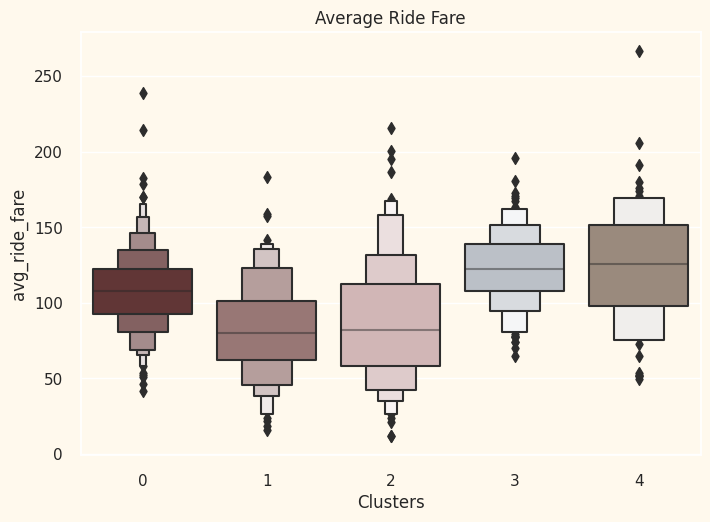

In [99]:
# Taking a look at raw average fare acceptance as continuous variable

plt.figure()
pl=sns.boxenplot(y=df_bivar["avg_ride_fare"],x=df_bivar["Clusters"], palette= pal)
pl.set_title("Average Ride Fare")
plt.show()

* We see that Group 0 has the biggest range with accepted ride fare. More lenient with diversity of rides.  
* On the flip side, Group 3 only accepts a specific range. 
* Group 2 accepts ride fares at relatively lower range
* Groups 1 and 4 have similar variance with 4 accepting rides at similar value as Group 3.

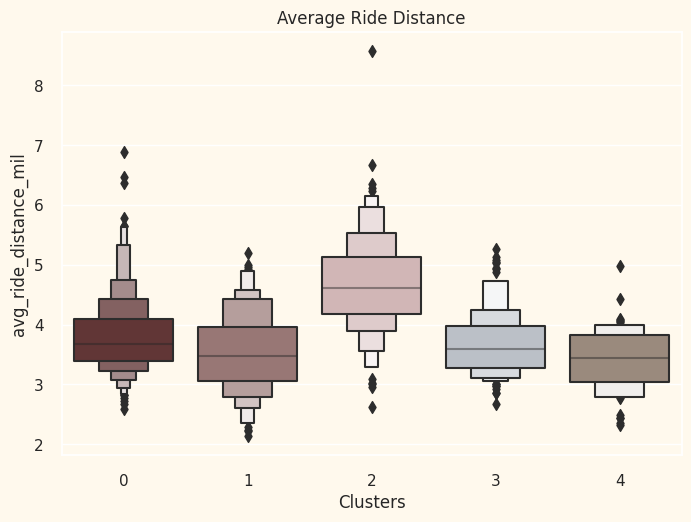

In [100]:
# Taking a look at average ride distance that is being accepted

plt.figure()
pl=sns.boxenplot(y=df_bivar["avg_ride_distance_mil"],x=df_bivar["Clusters"], palette= pal)
pl.set_title("Average Ride Distance")
plt.show()

* Group 0 and Group 2 accept long rides 
* Groups 1, 3 and 4 accept rides that are around the usual distance. 

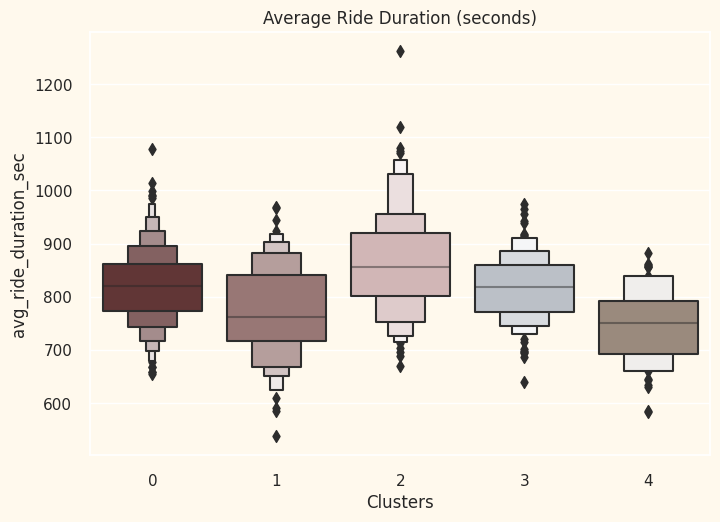

In [101]:
# Taking a look at average ride duration that is being accepted

plt.figure()
pl=sns.boxenplot(y=df_bivar["avg_ride_duration_sec"],x=df_bivar["Clusters"], palette= pal)
pl.set_title("Average Ride Duration (seconds)")
plt.show()

Very much similar distribution and variance to ride distance.

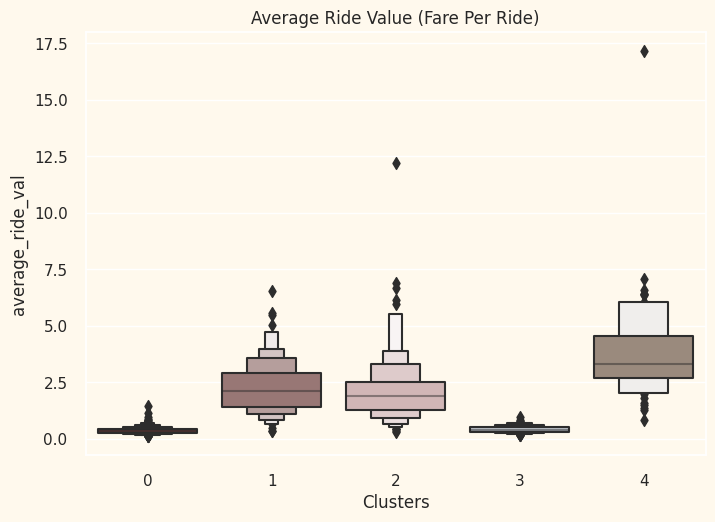

In [102]:
# Taking a look at average ride value (ride fare/ride count, fare per ride)

plt.figure()
pl=sns.boxenplot(y=df_bivar["average_ride_val"],x=df_bivar["Clusters"], palette= pal)
pl.set_title("Average Ride Value (Fare Per Ride)")
plt.show()

* Group 0 has the highest fares per ride. They get paid out more. 
* Group 2 has second highest fares, but not the highest.
* Group 3 is in 3rd place.
* Groups 1 and 4 are similar in fare value per ride.

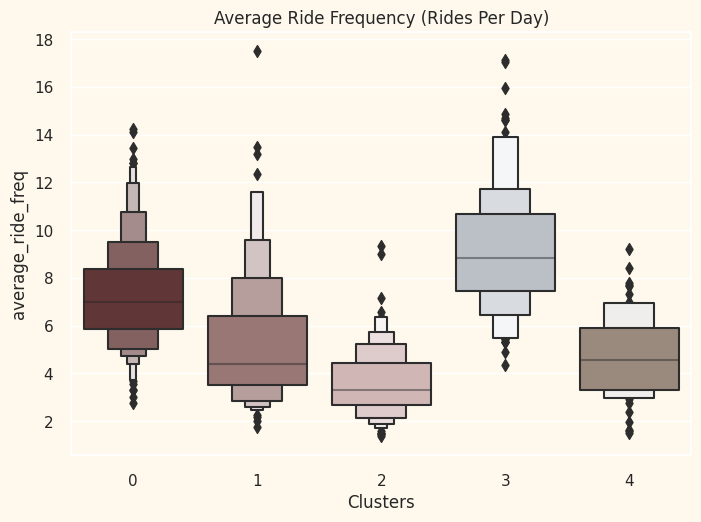

In [103]:
# Taking a look at average ride frequency (ride count/unique drive days, rides per day)

plt.figure()
pl=sns.boxenplot(y=df_bivar["average_ride_freq"],x=df_bivar["Clusters"], palette= pal)
pl.set_title("Average Ride Frequency (Rides Per Day)")
plt.show()

Interesting. 
* Group 0 has highest fare per ride but lowest number of rides per day.
* Group 2 has second to the lowest number of rides per day.
* Groups 1, 3 and 4 are the most similar in rides per day.

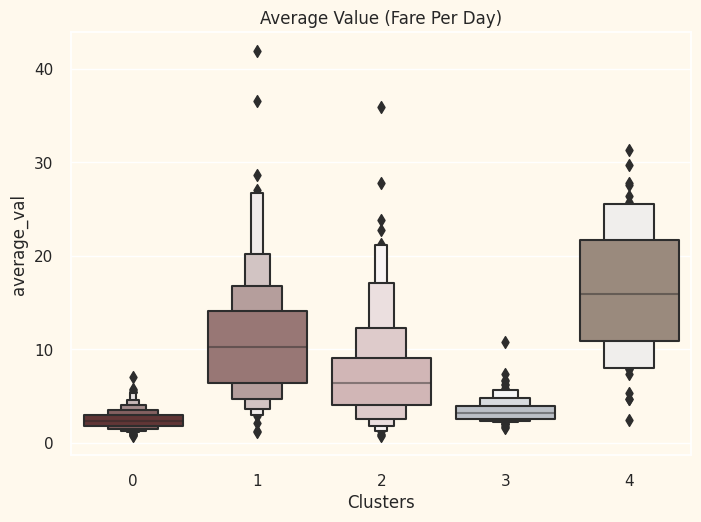

In [104]:
# Taking a look at average value (fare per day)

plt.figure()
pl=sns.boxenplot(y=df_bivar["average_val"],x=df_bivar["Clusters"], palette= pal)
pl.set_title("Average Value (Fare Per Day)")
plt.show()

* Groups 0 and 2 are definitely maximizing their day with receiving the highest fare per day. 
* Group 3 is in third place, but much behind Groups 0 and 2. 
* Groups 1 and 4 are closest to Group 3.

# Campaign Profiling

Now that we have formed the clusters and looked at their ride acceptance habits, let us see who is in each of these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star driver and who needs more attention from the Lyft's marketing team.

To decide that I will be plotting some of the features that are indicative of the driver's personal traits in light of the cluster they are in. On the basis of the outcomes, I will be arriving at the conclusions.

<Figure size 800x550 with 0 Axes>

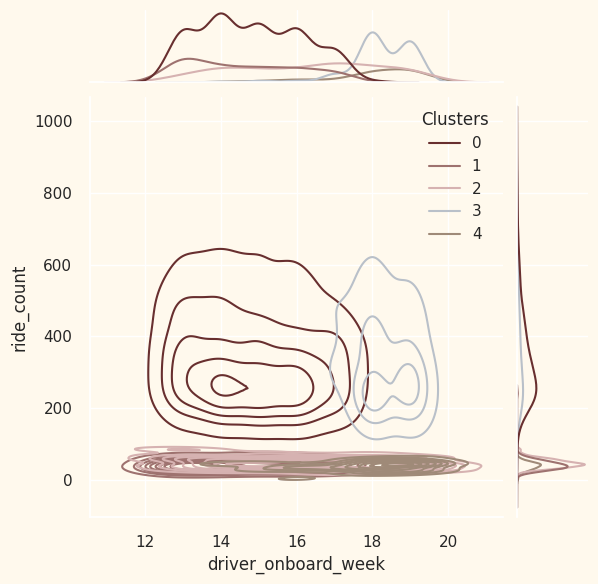

<Figure size 800x550 with 0 Axes>

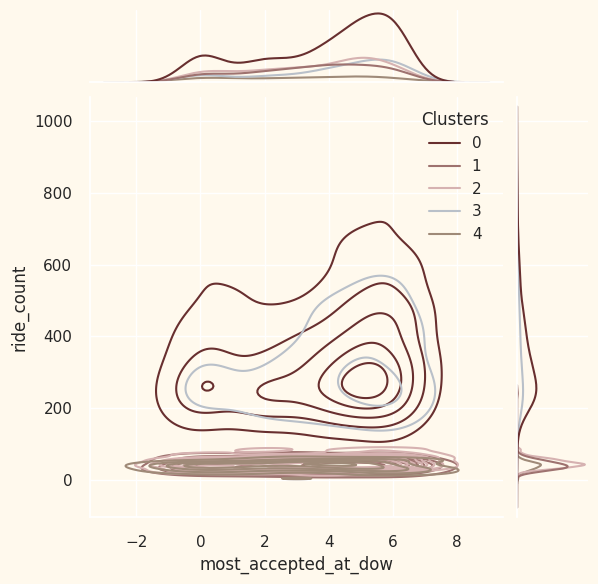

<Figure size 800x550 with 0 Axes>

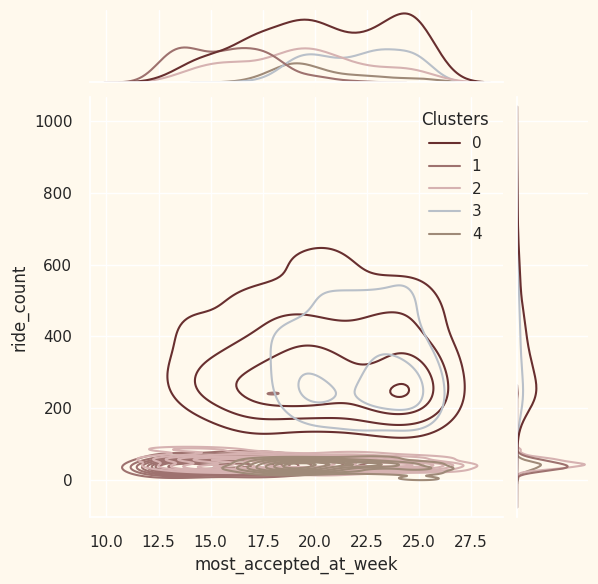

<Figure size 800x550 with 0 Axes>

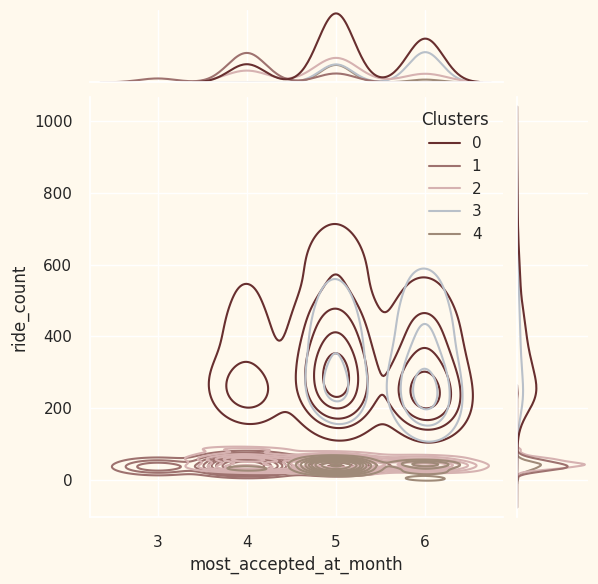

<Figure size 800x550 with 0 Axes>

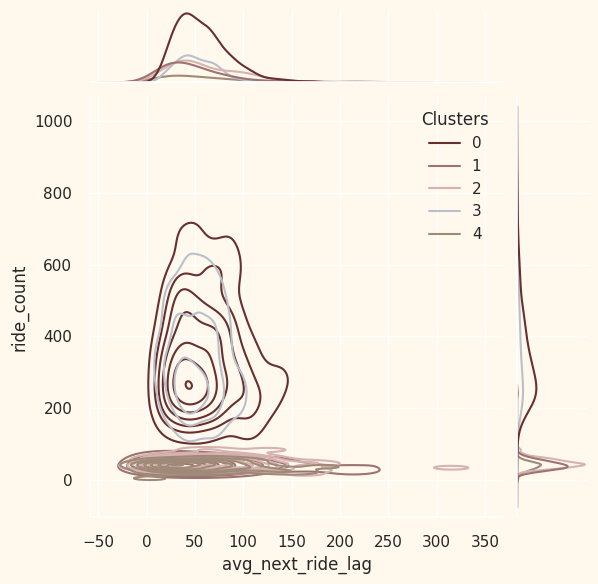

<Figure size 800x550 with 0 Axes>

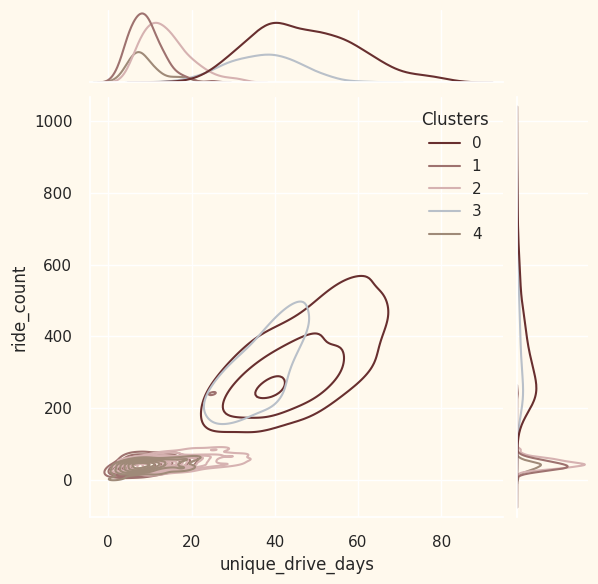

<Figure size 800x550 with 0 Axes>

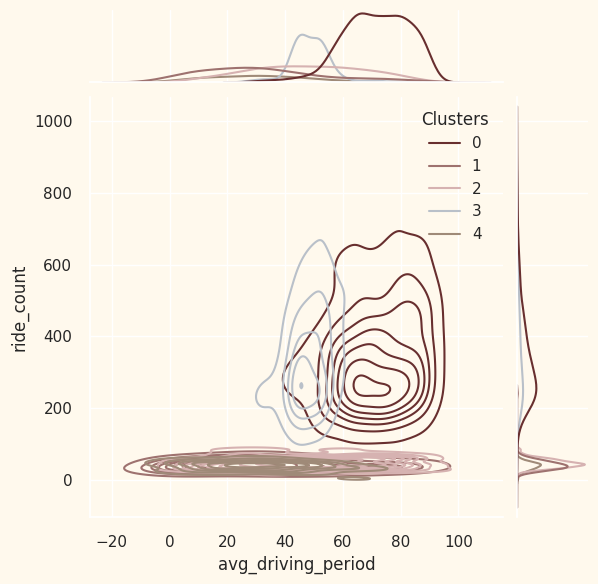

<Figure size 800x550 with 0 Axes>

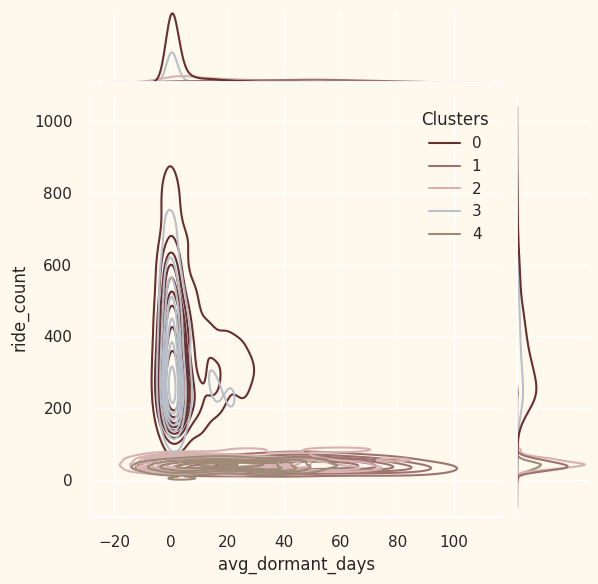

In [105]:
# driver traits versus ride traits
Personal = [ 
 'driver_onboard_week',
 'most_accepted_at_dow',
 'most_accepted_at_week',
 'most_accepted_at_month',
 'avg_next_ride_lag',
 'unique_drive_days',
 'avg_driving_period',
 'avg_dormant_days']

for i in Personal:
    plt.figure()
    sns.jointplot(x=df_bivar[i], y=df_bivar["ride_count"], hue =df_bivar["Clusters"], kind="kde", palette=pal)
    plt.show()

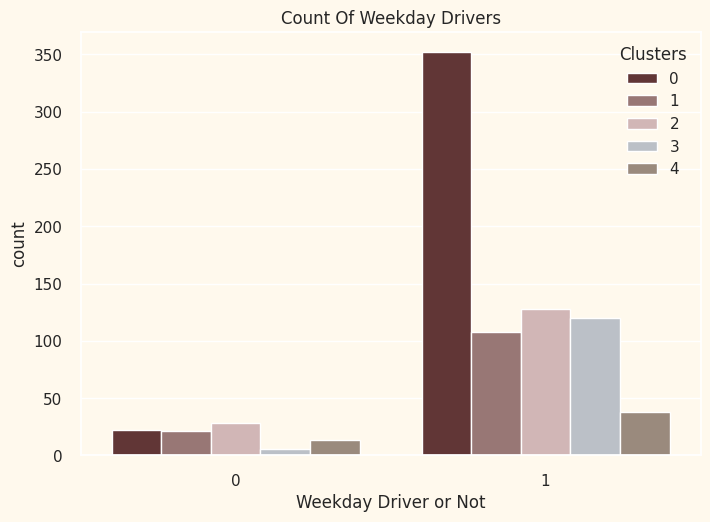

In [106]:
# Let's take a look at weekday drivers broken down
plt.figure()
pl = sns.countplot(x=df_bivar["weekday_driver"],hue=df_bivar["Clusters"], palette= pal)
pl.set_title("Count Of Weekday Drivers")
pl.set_xlabel("Weekday Driver or Not")
plt.show()

Mostly weekday drivers in general. 

* For those who are not weekday drivers, most of them come from Group 0 with Group 2 far behind.

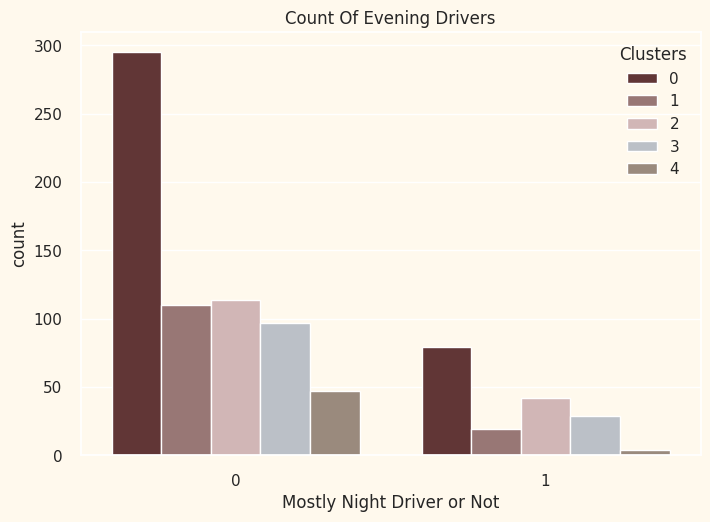

In [107]:
# Let's take a look at night drivers broken down
plt.figure()
pl = sns.countplot(x=df_bivar["evening_driver"],hue=df_bivar["Clusters"], palette= pal)
pl.set_title("Count Of Evening Drivers")
pl.set_xlabel("Mostly Night Driver or Not")
plt.show()

* We can see here that drivers mostly drive during the day.
* Of the night drivers, most of them in Group 1.
* There are no night drivers in Group3.
* Extremely seldom amount of night drivers in Group 4.

# Observations from Profiling

* Group 0: 
** accepts rides during early part of the week
** started accepting rides at week: 20 (May/June)
** least unique drive days (on the platform the least)
** second to the shortest tenure 
** most dormant days
** of the weekend drivers, highest %
** accepts high ride fares
** longest ride distances
** longest ride duration
** highest ride value
** fewest rides/day
** highest fare/day with huge variance
* Group 1: 
** accepts rides during late part of the week
** of the night drivers, highest %
** low ride value
** approximately 7 rides/day
* Group 2: 
** weekend driver (Fri Sat, Sun)
** started accepting rides at week: 15 (March/April)
** has shortest lag (time difference) between rides
** least unique drive days (on the platform the least)
** shortest tenure 
** most dormant days
** accepts lowest ride fares
** longest ride distances
** longest ride duration
** second highest ride value
** few rides/day
** highest fare/day with huge variance
* Group 3: 
** weekend driver (Fri Sat, Sun)
** has greatest lag (time difference) between rides
** most unique drive days (on the platform the most)
** longest tenure 
** lowest ride value
** approximately 7 rides/day
** lowest fare/day
* Group 4: 
** weekend driver (Fri Sat, Sun)
** started accepting rides mostly at week: 25
** no dormant days
** low ride value
** approximately 7 rides/day

# Driver Behavior Summary and Business Recommendations (so far)
## Behavior:
* Group 0 (Power Group): is exclusively driving big fare (long distance) rides
* Group 1 (Casual Night/Weekend Group): extremely part-time, gets mediocre rides, (night and weekend driver only)
* Group 2 (Power Weekend Group): similar to Group 0 but accepts low fares, but averages out to high fare/day
* Group 3 (Medium Weekend Group): non-motivated, low fare rides, but long tenure
* Group 4 (Fresh Weekend Group): in beginning stages of driving

## Recommendations:
* For Power Groups, provide rewards for taking the long rides and have them possibly expand driving on days in the week they do not already to get more opportunities especially for Group 0 that does not drive on weekends
* For Medium Weekend Group, they are trying to keep with the platform despite it not meeting their expectations. They are most likely going to churn (further investigation into this later). Need to encourage them to take on longer distance rides/offer higher fare rides. Remind them of  car maintenance/event ticket rewards
* For Casual Night/Weekend Group: this is a driver not invested in platform much. provide encouraging nudges to get drivers to drive during other part of week if possible and offer incentives to accept higher fare rides, promotions when driving during the day (higher fare)
* Fpr Fresh Weekend Group: looks like they are in exploratory phase, testing out the platform. For these, make sure while they are still open to the platform to push hard on positive view of platform by offering big fare rides, car maintenance/event ticket rewards

# Other Business Operations Questions

In [108]:
# Percent drivers who have not started driving yet
query = """
with cte as (select -- round(sum(case when r.driver_id is null then 1 else 0 end)/count(distinct d.driver_id) * 100.0, 2) as drivers_no_rides_perc
 d.driver_id
, r.driver_id as driver_id2
from drivers d
left join rides r
on d.driver_id = r.driver_id
group by 1, 2
)

select round(sum(case when driver_id2 IS NULL then 1 else 0 end)/count(*) * 100, 2) as drivers_no_rides_perc
from cte
"""

duckdb.query(query).df() 

,drivers_no_rides_perc
0,8.86


In light of what is given in the assignment prompt:

* *snapshot of onboarding and ride history for 3 month period*
* *may assume data is complete for these drivers during given time period*
* *additional rides may have occurred before and after the time period included in the data*

Possible reasons for this mismatch:

* not all drivers have started completing rides
* not all rides have drivers from driver onboard time range
* not all rides have ride events logged

## How does the demand for rides impact the number of drivers?

In [109]:
# Need to get same window of time between drivers and rides and do a count 
# to look at demand vs supply
# and this needs to be broken down at week level

# use correlation coefficient (Pearson's) to see how rides demand affect drivers (already onboarded)

ride_timestamps[ride_timestamps['event'] == 'requested_at']['timestamp'].min(), ride_timestamps[ride_timestamps['event']=='requested_at']['timestamp'].max()

(Timestamp('2016-03-28 05:48:18'), Timestamp('2016-06-26 23:57:45'))

In [110]:
# need to look at number of drivers driving during same time frame
# per date, get count distinct drivers accepting rides (assuming number of rides per driver go up) - seems like question is asking that as demand goes up, distinct drivers during time frame goes up

#how: get drivers who took rides and add that to dataframe of ride_timestamps2

query = """
select driver_id
, t2.*
from rides t1
join ride_timestamps2 t2
on t1.ride_id = t2.ride_id
"""

dr = duckdb.query(query).df()
dr['requested_at_date'] = dr['requested_at_ts'].dt.date
dr['requested_at_week'] = dr['requested_at_ts'].dt.isocalendar().week

In [111]:
# aggregate table at appropriate levels

result = dr.groupby('requested_at_week').agg(
    count_category=('ride_id', 'size'),
    count_distinct_item=('driver_id', 'nunique')
).reset_index()

# Re-name columns
result.columns = ['requested_at_week', 'total_rides', 'distinct_drivers']

# Display the result
result

,requested_at_week,total_rides,distinct_drivers
0,13,2498,127
1,14,5865,261
2,15,7798,355
3,16,10292,454
4,17,13656,528
5,18,15770,617
6,19,19551,669
7,20,19678,629
8,21,18221,604
9,22,17835,594


<Axes: xlabel='requested_at_week'>

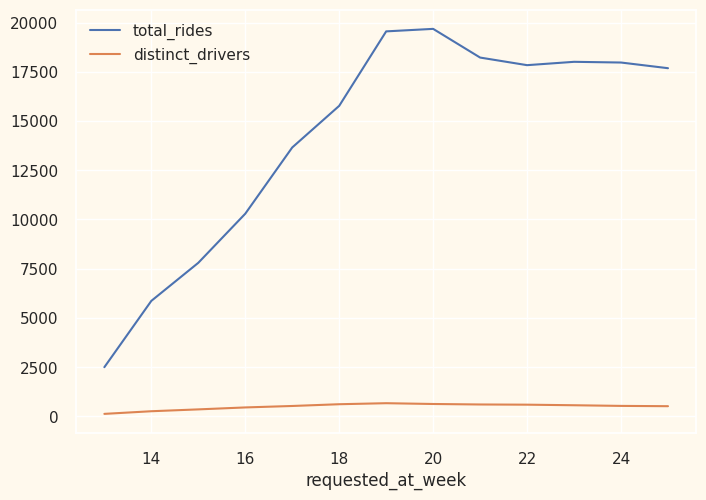

In [112]:
result.plot.line(x='requested_at_week', y= ['total_rides', 'distinct_drivers'])

In [113]:
# Calculate Pearson's correlation between total rides and distinct number of drivers during same window of time
result['total_rides'].corr(result['distinct_drivers'])

0.952791651434362

From the graph alone, it looks like driver numbers were not impacted immesenly as ride numbers climbed. Drivers just took on more rides as demand peaked.

However, when performing Pearson's correlation we see that as demand grows for rides, so does the supply of drivers in order to meet the need. The graph just is not scaled in a way to see that relationship.

# Driver Retention Over Time By Onboard Week Cohort
% of active drivers in weekly buckets

In [114]:
# Strategy to Calculate Retention Over Time

# 1st column: get onboard date - cohort (attained)
# 2nd column: get total attained for each cohort onboard week
# for period 1,2,3, etc. out from onboard date get total active drivers with x week out from onboard date
# get percent by dividing total active drivers from x week out from onboard date/drivers attained

In [115]:
query = """
select count(distinct driver_id)
from df_feat
"""
duckdb.query(query).df()

,count(DISTINCT driver_id)
0,837


In [116]:
query = """
select count(*)
from df_feat
where last_activity is not null
"""
duckdb.query(query).df()

,count_star()
0,837


In [117]:
# Raw Retention
query = """

select driver_onboard_week as cohort
, count(distinct driver_id) as drivers_attained
, count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week then driver_id else null end)/drivers_attained as retained_wk0_from_onboard
, count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 1 then driver_id else null end)/drivers_attained as retained_wk1_from_onboard
, count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 2 then driver_id else null end)/drivers_attained as retained_wk2_from_onboard
, count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 3 then driver_id else null end)/drivers_attained as retained_wk3_from_onboard
, count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 4 then driver_id else null end)/drivers_attained as retained_wk4_from_onboard
, count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 5 then driver_id else null end)/drivers_attained as retained_wk5_from_onboard
, count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 6 then driver_id else null end)/drivers_attained as retained_wk6_from_onboard

from df_feat
group by 1
order by 1

"""

retention = duckdb.query(query).df()
retention

,cohort,drivers_attained,retained_wk0_from_onboard,retained_wk1_from_onboard,retained_wk2_from_onboard,retained_wk3_from_onboard,retained_wk4_from_onboard,retained_wk5_from_onboard,retained_wk6_from_onboard
0,13,128,0.984375,0.875000,0.757812,0.710938,0.679688,0.664062,0.648438
1,14,148,0.986486,0.885135,0.837838,0.763514,0.763514,0.682432,0.675676
2,15,127,0.984252,0.905512,0.795276,0.795276,0.716535,0.724409,0.700787
3,16,123,0.959350,0.934959,0.878049,0.829268,0.731707,0.691057,0.723577
4,17,111,0.972973,0.891892,0.819820,0.756757,0.765766,0.720721,0.639640
5,18,104,1.000000,0.961538,0.865385,0.807692,0.759615,0.711538,0.653846
6,19,96,0.979167,0.916667,0.875000,0.770833,0.760417,0.687500,0.697917


In [118]:
query = """

select driver_onboard_week as cohort
, count(distinct driver_id) as drivers_attained
, concat(round(count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week then driver_id else null end)/drivers_attained * 100), '%') as retained_wk0_from_onboard_perc
, concat(round(count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 1 then driver_id else null end)/drivers_attained * 100), '%') as retained_wk1_from_onboard_perc
, concat(round(count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 2 then driver_id else null end)/drivers_attained * 100), '%') as retained_wk2_from_onboard_perc
, concat(round(count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 3 then driver_id else null end)/drivers_attained * 100), '%') as retained_wk3_from_onboard_perc
, concat(round(count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 4 then driver_id else null end)/drivers_attained * 100), '%') as retained_wk4_from_onboard_perc
, concat(round(count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 5 then driver_id else null end)/drivers_attained * 100), '%') as retained_wk5_from_onboard_perc
, concat(round(count(distinct case when churn = 0 and accepted_at_week = driver_onboard_week + 6 then driver_id else null end)/drivers_attained * 100), '%') as retained_wk6_from_onboard_perc

from df_feat
group by 1
order by 1

"""

retention2 = duckdb.query(query).df()
retention2

,cohort,drivers_attained,retained_wk0_from_onboard_perc,retained_wk1_from_onboard_perc,retained_wk2_from_onboard_perc,retained_wk3_from_onboard_perc,retained_wk4_from_onboard_perc,retained_wk5_from_onboard_perc,retained_wk6_from_onboard_perc
0,13,128,98.0%,88.0%,76.0%,71.0%,68.0%,66.0%,65.0%
1,14,148,99.0%,89.0%,84.0%,76.0%,76.0%,68.0%,68.0%
2,15,127,98.0%,91.0%,80.0%,80.0%,72.0%,72.0%,70.0%
3,16,123,96.0%,93.0%,88.0%,83.0%,73.0%,69.0%,72.0%
4,17,111,97.0%,89.0%,82.0%,76.0%,77.0%,72.0%,64.0%
5,18,104,100.0%,96.0%,87.0%,81.0%,76.0%,71.0%,65.0%
6,19,96,98.0%,92.0%,88.0%,77.0%,76.0%,69.0%,70.0%


In [119]:
# Retention WoW %

query = """

select cohort
, drivers_attained
, round((retained_wk1_from_onboard - retained_wk0_from_onboard)/retained_wk0_from_onboard *100, 2) as retained_wk_1_wow_perc
, round((retained_wk2_from_onboard - retained_wk1_from_onboard)/retained_wk1_from_onboard *100, 2) as retained_wk_2_wow_perc
, round((retained_wk3_from_onboard - retained_wk2_from_onboard)/retained_wk2_from_onboard *100, 2) as retained_wk_3_wow_perc
, round((retained_wk4_from_onboard - retained_wk3_from_onboard)/retained_wk3_from_onboard *100, 2) as retained_wk_4_wow_perc
, round((retained_wk5_from_onboard - retained_wk4_from_onboard)/retained_wk4_from_onboard *100, 2) as retained_wk_5_wow_perc
, round((retained_wk6_from_onboard - retained_wk5_from_onboard)/retained_wk5_from_onboard *100, 2) as retained_wk_6_wow_perc

from retention
order by 1
"""

retention3 = duckdb.query(query).df()
retention3

,cohort,drivers_attained,retained_wk_1_wow_perc,retained_wk_2_wow_perc,retained_wk_3_wow_perc,retained_wk_4_wow_perc,retained_wk_5_wow_perc,retained_wk_6_wow_perc
0,13,128,-11.11,-13.39,-6.19,-4.40,-2.30,-2.35
1,14,148,-10.27,-5.34,-8.87,0.00,-10.62,-0.99
2,15,127,-8.00,-12.17,0.00,-9.90,1.10,-3.26
3,16,123,-2.54,-6.09,-5.56,-11.76,-5.56,4.71
4,17,111,-8.33,-8.08,-7.69,1.19,-5.88,-11.25
5,18,104,-3.85,-10.00,-6.67,-5.95,-6.33,-8.11
6,19,96,-6.38,-4.55,-11.90,-1.35,-9.59,1.52


In [120]:
# Multi-line line graph

query = """

UNPIVOT retention
ON retained_wk0_from_onboard, retained_wk1_from_onboard, retained_wk2_from_onboard, retained_wk3_from_onboard, retained_wk4_from_onboard, retained_wk5_from_onboard, retained_wk6_from_onboard
INTO
    NAME cohort
    VALUE retained;
    
"""
retention_pivot = duckdb.query(query).df()
retention_pivot

,cohort,drivers_attained,cohort_1,retained
0,13,128,retained_wk0_from_onboard,0.984375
1,13,128,retained_wk1_from_onboard,0.875000
2,13,128,retained_wk2_from_onboard,0.757812
3,13,128,retained_wk3_from_onboard,0.710938
4,13,128,retained_wk4_from_onboard,0.679688
5,13,128,retained_wk5_from_onboard,0.664062
6,13,128,retained_wk6_from_onboard,0.648438
7,14,148,retained_wk0_from_onboard,0.986486
8,14,148,retained_wk1_from_onboard,0.885135
9,14,148,retained_wk2_from_onboard,0.837838


cohort
13    Axes(0.125,0.11;0.775x0.77)
14    Axes(0.125,0.11;0.775x0.77)
15    Axes(0.125,0.11;0.775x0.77)
16    Axes(0.125,0.11;0.775x0.77)
17    Axes(0.125,0.11;0.775x0.77)
18    Axes(0.125,0.11;0.775x0.77)
19    Axes(0.125,0.11;0.775x0.77)
Name: retained, dtype: object

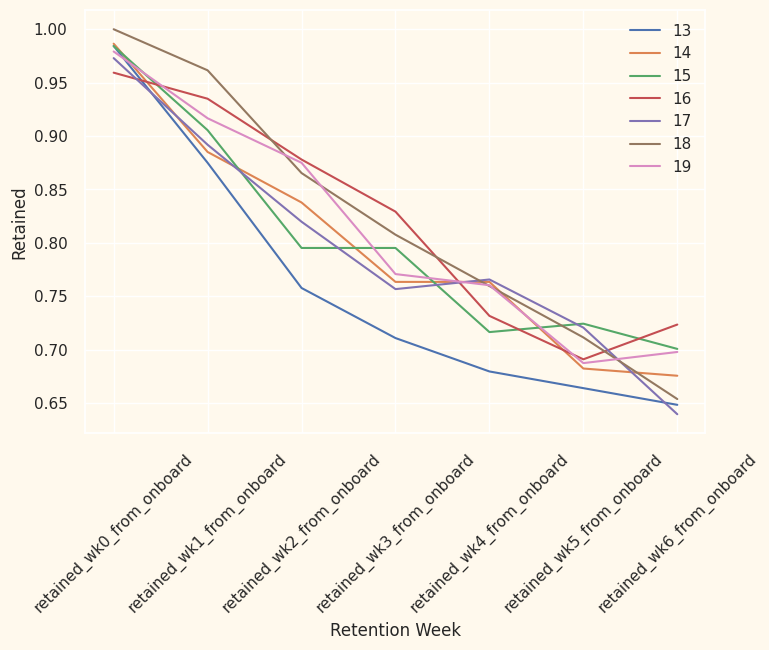

In [121]:
retention_pivot.set_index("cohort_1", inplace=True)
retention_pivot.groupby("cohort")["retained"].plot(legend=True, xlabel="Retention Week", ylabel="Retained", rot=45)

We can look at row-wise (compare a cohort's WoW performance):
1. some drivers start driving right away (within the same week as they are onboarded - 100% of the drivers from cohort 18 which also has second to smallest cohort)
1. see that some cohorts have slight rise going from left to right (WoW is positive) meaning that some drivers may have started driving late since no condition in SQL logic for eliminating drivers from population who did not start driving at week 1 from onboard date
1. biggest WoW drop off's were 2 weeks out from onboard date
1. after week 2 from onboard date, WoW is not as drastic in change

Looking column-wise (compare different cohorts' retention per week):
1. whatever was done for week cohort 18 was success since all drivers started driving within onboarding week
1. in general, cohort 18 had highest retention rates across weeks until week 4 out. then retention rates became comparable to other cohorts
1. cohort 16 has relatively high retention rate as well

From the graph:
1. we can see cohort 13 (first one) has the lowest retention. seems like product/growth team did some work to increase retention rates since succeeding cohorts have higher retention WoW
1. although cohorts 15 and 17 have the steepest WoW retention after cohort 13, 15 slightly recovers 5 weeks out from onboard date, whereas cohort 17 continues to dip
1. cohorts 16 & 19 have the best uplift at week 5 from onboard date

# Predictive Indicators of Churn and LTV
Supervised Learning (Linear and Logistic Regression)

1. add back in targets (churn and ltv)
1. pick metric of interest
1. pick model candidates
1. prep features as necessary (transformation, scaling for Linear Regression)
1. optimize model with pruning, folding (hyper-parameter tuning for optimized settings)
1. pick model with best result
1. get feature importance to see which one is strongest correlators to target

* reference table: df_driver
* LTV (Linear Regression) metric of interest: RMSE
* Churn (Logistic Regression) metric of interest: AUC, ROC curve

* Linear Regression model candidates: 
1. Gradient Boosting Regressor (gbr)
1. Extreme Gradient Boosting (xgboost)
1. Extra Trees Regressor (et)
1. Random Forest Regressor (rf)
1. CatBoost Regressor (catboost)
1. AdaBoost Regressor (ada)
1. Decision Tree Regressor (dt)
1. Light Gradient Boosting Machine (lightgbm)
1. K Neighbors Regressor (knn)
1. Ridge Regression (ridge)
1. Elastic Net (en)
1. Lasso Regression (lasso)
1. Lasso Least Angle Regression (llar)
1. Bayesian Ridge (br)
1. Orthogonal Matching Pursuit (omp)
1. Huber Regressor (huber)
1. Linear Regression (lr)
1. Passive Aggressive Regressor (par)
1. Dummy Regressor (dummy)
1. Least Angle Regression (lar)

* Logistic Regression model candidates: 
1. Logistic Regression (lr)
1. CatBoost Classifier (catboost)
1. Light Gradient Boosting Machine (lightgbm)
1. Gradient Boosting Classifier (gbc)
1. Extreme Gradient Boosting (xgboost)
1. Linear Discriminant Analysis (lda)
1. Ada Boost Classifier (ada)
1. Extra Trees Classifier (et)
1. Random Forest Classifier (rf)
1. Naive Bayes (nb)
1. Decision Tree Classifier (dt)
1. K Neighbors Classifer (knn)
1. Quadratic Discriminant Analysis (qda)
1. Dummy Classifier (dummy)
1. SVM - Linear Kernel (svm)
1. Ridge Classifier (ridge)

To be continued in [Lyft Driver Lyft Business Analysis LTV Prediction notebook](https://github.com/mindyng/2024-Business-Projects/blob/main/lyft-business-analysis-ltv-prediction.ipynb).